In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgbm
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns


import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/anaconda3/envs/teachopencadd/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
levels_up = 3
HDAC6= HERE.parents[levels_up-1]/'input'

In [3]:
df = pd.read_pickle(HDAC6/"HDAC6_2971compounds_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl
0,CHEMBL356066,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6670835, 7057043, 2678397, 6116087, 19849001,...",379.189592,9.0,28.0,4.0,4.0,2.72350,3.0,0.0,0.0,8.02
1,CHEMBL3652228,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[35600637, 2478511, 10872982, 74375522, 394834...",244.096026,3.0,18.0,5.0,3.0,1.64762,2.0,0.0,0.0,8.05
2,CHEMBL3939518,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[13333824, 2632634, 1991683, 218190, 16674131,...",408.128983,11.0,27.0,7.0,3.0,3.71980,2.0,1.0,1.0,6.87
3,CHEMBL4281792,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1840283, 3913535, 8033062, 668868, 3328960, 4...",460.211055,5.0,34.0,5.0,2.0,2.87510,3.0,1.0,2.0,7.22
4,CHEMBL4070232,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5922349, 1506859, 1823034, 2469425, 5363609, ...",516.189651,10.0,38.0,8.0,2.0,4.47360,4.0,0.0,0.0,7.15


In [4]:
df_labeled = pd.read_csv(HDAC6/"HDAC6_2971compounds_withTypes-Ki_newThreshold.csv", index_col=0)
df_labeled

,molecule_chembl_id,smiles,pActivity,label
0,CHEMBL4082520,CN1C(=O)C2CN(Cc3c2c2cc(OCc4ccccc4)ccc2n3Cc2ccc...,10.10,Single points
1,CHEMBL4098975,O=C(CCCCCCC(=O)Nc1ccc(NCCCn2cc(-c3ncnc4[nH]ccc...,9.85,hDAC6-selective
2,CHEMBL4100534,COc1ccc2c(c1)c1c(n2Cc2ccc(C(=O)NO)cc2)CN2CC1C(...,9.82,Single points
3,CHEMBL4101480,COc1ccc2c(c1)c1c(n2Cc2ccc(C(=O)NO)cc2)CN2CC1C(...,9.80,Single points
4,CHEMBL3912061,CS(=O)(=O)NCCc1cn(Cc2ccc(C(=O)NO)cc2)c2ccccc12,9.77,hDAC6-selective
...,...,...,...,...
2966,CHEMBL1798006,CC[C@H](C)[C@H](NC(=O)C1CCNCC1)C(=O)N1Cc2cc(OC...,6.77,Single points
2967,CHEMBL470843,O=C(/C=C/c1ccc(-c2cc(CN3CCOCC3)on2)cc1)NO,6.76,Semi-selective
2968,CHEMBL1798004,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N1Cc2c...,6.72,Single points
2969,CHEMBL3215861,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC,6.61,Dual-binder


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')
df.head()

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl,label
0,CHEMBL356066,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6670835, 7057043, 2678397, 6116087, 19849001,...",379.189592,9.0,28.0,4.0,4.0,2.72350,3.0,0.0,0.0,8.02,Semi-selective
1,CHEMBL3652228,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[35600637, 2478511, 10872982, 74375522, 394834...",244.096026,3.0,18.0,5.0,3.0,1.64762,2.0,0.0,0.0,8.05,Semi-selective
2,CHEMBL3939518,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[13333824, 2632634, 1991683, 218190, 16674131,...",408.128983,11.0,27.0,7.0,3.0,3.71980,2.0,1.0,1.0,6.87,Dual-binder
3,CHEMBL4281792,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1840283, 3913535, 8033062, 668868, 3328960, 4...",460.211055,5.0,34.0,5.0,2.0,2.87510,3.0,1.0,2.0,7.22,Single points
4,CHEMBL4070232,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5922349, 1506859, 1823034, 2469425, 5363609, ...",516.189651,10.0,38.0,8.0,2.0,4.47360,4.0,0.0,0.0,7.15,Dual-binder


In [6]:
#df['Classes'] = np.where(df['label']== 'hDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'hDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'hDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl,label,Class
0,CHEMBL356066,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6670835, 7057043, 2678397, 6116087, 19849001,...",379.189592,9.0,28.0,4.0,4.0,2.72350,3.0,0.0,0.0,8.02,Semi-selective,5.0
1,CHEMBL3652228,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[35600637, 2478511, 10872982, 74375522, 394834...",244.096026,3.0,18.0,5.0,3.0,1.64762,2.0,0.0,0.0,8.05,Semi-selective,5.0
2,CHEMBL3939518,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[13333824, 2632634, 1991683, 218190, 16674131,...",408.128983,11.0,27.0,7.0,3.0,3.71980,2.0,1.0,1.0,6.87,Dual-binder,3.0
3,CHEMBL4281792,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1840283, 3913535, 8033062, 668868, 3328960, 4...",460.211055,5.0,34.0,5.0,2.0,2.87510,3.0,1.0,2.0,7.22,Single points,0.0


In [7]:
# Add column for activity
df["activity"] = np.zeros(len(df))

# Mark every molecule as active if pchembl value is >=6.6 0 otherwise
df.loc[df[df.pchembl >= 6.6].index, "activity"] = 1.0

#By using Morgan fingerprints with radius of 3 and 1024 bits
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y = df["pchembl"].values
Y_cat =  df["activity"].values
Y_class = df['Class'].values
indices =  np.array(df.index)


In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['pchembl'])).astype(float)
    globals_dict[f"Y_trainSet{i}_cat"] = np.array(list(df.iloc[index_tr_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['pchembl'])).astype(float)
    globals_dict[f"Y_testSet{i}_cat"] = np.array(list(df.iloc[index_te_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_reg =  RandomForestRegressor(random_state=1121218, max_features = None, n_jobs=8,oob_score=True,
                                           max_samples=0.8, )
        rf_reg.fit(x_train, y_train)
        y_pred = rf_reg.predict(x_test)  
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6) , 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)



mat_met_rf = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    R2         0.693683     0.042858
1                    TP       166.200000     6.408328
2                    TN        88.500000     7.989577
3                    FP        24.900000     5.989806
4                    FN        17.500000     5.562773
5              Accuracy         0.857290     0.023371
6             Precision         0.870614     0.025897
7           Sensitivity         0.904813     0.029567
8           Specificity         0.779790     0.054270
9              F1 score         0.886916     0.017984
10  F1 score (weighted)         0.856109     0.023678
11     F1 score (macro)         0.846320     0.026168
12    Balanced Accuracy         0.842301     0.027134
13                  MCC         0.695561     0.050915
14                  NPV         0.836320     0.041900
15              ROC_AUC         0.842301     0.027134
CPU times: user 1min 57s, sys: 62.8 ms, total: 1min 57s
Wall time: 16 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestRegressor(**param_grid, n_jobs=8, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestRegressor(**param_grid, n_jobs=8, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFRegressor")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 10:12:36,863] A new study created in memory with name: RFRegressor
[I 2023-02-20 10:13:32,328] Trial 0 finished with value: 0.678994850425892 and parameters: {'n_estimators': 467}. Best is trial 0 with value: 0.678994850425892.
[I 2023-02-20 10:15:33,872] Trial 1 finished with value: 0.6796615212674724 and parameters: {'n_estimators': 923}. Best is trial 1 with value: 0.6796615212674724.
[I 2023-02-20 10:16:56,056] Trial 2 finished with value: 0.6792106057770427 and parameters: {'n_estimators': 536}. Best is trial 1 with value: 0.6796615212674724.
[I 2023-02-20 10:18:20,576] Trial 3 finished with value: 0.6793797660048344 and parameters: {'n_estimators': 542}. Best is trial 1 with value: 0.6796615212674724.
[I 2023-02-20 10:20:52,039] Trial 4 finished with value: 0.6797309732072196 and parameters: {'n_estimators': 990}. Best is trial 4 with value: 0.6797309732072196.
[I 2023-02-20 10:23:09,256] Trial 5 finished with value: 0.6796257951550755 and parameters: {'n_estimators

[I 2023-02-20 11:44:03,760] Trial 46 finished with value: 0.6796204092034388 and parameters: {'n_estimators': 744}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 11:46:37,976] Trial 47 finished with value: 0.6797359785963604 and parameters: {'n_estimators': 999}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 11:48:54,800] Trial 48 finished with value: 0.6796397050292091 and parameters: {'n_estimators': 896}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 11:51:03,621] Trial 49 finished with value: 0.6797512513727371 and parameters: {'n_estimators': 837}. Best is trial 36 with value: 0.6797576113523447.


	Number of trials: 50.0
	Best value (r2_score): 0.6798
	Best params:
		n_estimators: 765


In [14]:
optimized_rf_0 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_rf_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_0_cat = np.where((y_pred_rf_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_rf_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_rf_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_rf_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_rf_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_rf_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_rf_0_cat)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    R2    0.672213
1                    TP  313.000000
2                    TN  178.000000
3                    FP   59.000000
4                    FN   45.000000
5              Accuracy    0.825210
6             Precision    0.841398
7           Sensitivity    0.874302
8           Specificity    0.751100
9              F1 score    0.857534
10  F1 score (weighted)    0.824226
11     F1 score (macro)    0.815724
12    Balanced Accuracy    0.812678
13                  MCC    0.632440
14                  NPV    0.798200
15              ROC_AUC    0.812678


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 11:53:15,730] Trial 50 finished with value: 0.6684998088132157 and parameters: {'n_estimators': 769}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 11:55:20,223] Trial 51 finished with value: 0.6688355567235549 and parameters: {'n_estimators': 824}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 11:56:50,781] Trial 52 finished with value: 0.6689286519897982 and parameters: {'n_estimators': 578}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 11:59:25,959] Trial 53 finished with value: 0.6686924785754835 and parameters: {'n_estimators': 999}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 12:01:38,726] Trial 54 finished with value: 0.668876967662482 and parameters: {'n_estimators': 852}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 12:03:22,330] Trial 55 finished with value: 0.6689355416781942 and parameters: {'n_estimators': 675}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-

[I 2023-02-20 13:35:39,235] Trial 97 finished with value: 0.6685933877550347 and parameters: {'n_estimators': 748}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 13:37:58,857] Trial 98 finished with value: 0.6689107367478547 and parameters: {'n_estimators': 908}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 13:40:29,282] Trial 99 finished with value: 0.6688574078572296 and parameters: {'n_estimators': 974}. Best is trial 36 with value: 0.6797576113523447.


	Number of trials: 100.0
	Best value (r2_score): 0.6798
	Best params:
		n_estimators: 765


In [16]:
optimized_rf_1 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_rf_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_1_cat = np.where((y_pred_rf_1 >= 6.6), 1, 0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_rf_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_rf_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_rf_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_rf_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_rf_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_rf_1_cat)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    R2    0.672213    0.730588
1                    TP  313.000000  336.000000
2                    TN  178.000000  174.000000
3                    FP   59.000000   44.000000
4                    FN   45.000000   41.000000
5              Accuracy    0.825210    0.857143
6             Precision    0.841398    0.884211
7           Sensitivity    0.874302    0.891247
8           Specificity    0.751100    0.798200
9              F1 score    0.857534    0.887715
10  F1 score (weighted)    0.824226    0.856931
11     F1 score (macro)    0.815724    0.845705
12    Balanced Accuracy    0.812678    0.844706
13                  MCC    0.632440    0.691459
14                  NPV    0.798200    0.809300
15              ROC_AUC    0.812678    0.844706


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 13:41:21,164] Trial 100 finished with value: 0.6781035258159951 and parameters: {'n_estimators': 238}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 13:43:36,106] Trial 101 finished with value: 0.6792712560048747 and parameters: {'n_estimators': 855}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 13:46:06,889] Trial 102 finished with value: 0.6794616698497874 and parameters: {'n_estimators': 960}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 13:48:44,416] Trial 103 finished with value: 0.6794721839583381 and parameters: {'n_estimators': 998}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 13:51:08,991] Trial 104 finished with value: 0.6793646537014343 and parameters: {'n_estimators': 924}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 13:53:26,493] Trial 105 finished with value: 0.6792569522600447 and parameters: {'n_estimators': 879}. Best is trial 36 with value: 0.6797576113523447.
[I 2

[I 2023-02-20 15:28:39,838] Trial 146 finished with value: 0.6792901132424142 and parameters: {'n_estimators': 809}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 15:31:02,500] Trial 147 finished with value: 0.6793523035682376 and parameters: {'n_estimators': 887}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 15:33:36,291] Trial 148 finished with value: 0.6795031260504559 and parameters: {'n_estimators': 966}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 15:36:07,983] Trial 149 finished with value: 0.6794308422644677 and parameters: {'n_estimators': 946}. Best is trial 36 with value: 0.6797576113523447.


	Number of trials: 150.0
	Best value (r2_score): 0.6798
	Best params:
		n_estimators: 765


In [18]:

optimized_rf_2 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_rf_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_2_cat = np.where((y_pred_rf_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_rf_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_rf_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_rf_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_rf_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_rf_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_rf_2_cat)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.672213    0.730588    0.709249
1                    TP  313.000000  336.000000  319.000000
2                    TN  178.000000  174.000000  192.000000
3                    FP   59.000000   44.000000   45.000000
4                    FN   45.000000   41.000000   39.000000
5              Accuracy    0.825210    0.857143    0.858824
6             Precision    0.841398    0.884211    0.876374
7           Sensitivity    0.874302    0.891247    0.891061
8           Specificity    0.751100    0.798200    0.810100
9              F1 score    0.857534    0.887715    0.883657
10  F1 score (weighted)    0.824226    0.856931    0.858505
11     F1 score (macro)    0.815724    0.845705    0.852085
12    Balanced Accuracy    0.812678    0.844706    0.850594
13                  MCC    0.632440    0.691459    0.704358
14                  NPV    0.798200    0.809300    0.831200
15              ROC_AUC    0.812678    0

In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 15:38:03,037] Trial 150 finished with value: 0.669809370020517 and parameters: {'n_estimators': 649}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 15:40:02,480] Trial 151 finished with value: 0.6700734831398043 and parameters: {'n_estimators': 764}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 15:41:57,515] Trial 152 finished with value: 0.6701685431628259 and parameters: {'n_estimators': 746}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 15:44:07,038] Trial 153 finished with value: 0.6701164858670257 and parameters: {'n_estimators': 828}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 15:46:42,345] Trial 154 finished with value: 0.6703037563353857 and parameters: {'n_estimators': 1000}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 15:48:35,730] Trial 155 finished with value: 0.6703053114924886 and parameters: {'n_estimators': 721}. Best is trial 36 with value: 0.6797576113523447.
[I 2

[I 2023-02-20 17:09:12,332] Trial 196 finished with value: 0.6702162363061422 and parameters: {'n_estimators': 981}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 17:11:21,899] Trial 197 finished with value: 0.67019761936223 and parameters: {'n_estimators': 954}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 17:13:17,951] Trial 198 finished with value: 0.6701125512335588 and parameters: {'n_estimators': 841}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 17:15:36,047] Trial 199 finished with value: 0.6703619816536939 and parameters: {'n_estimators': 999}. Best is trial 36 with value: 0.6797576113523447.


	Number of trials: 200.0
	Best value (r2_score): 0.6798
	Best params:
		n_estimators: 765


In [20]:
optimized_rf_3 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_rf_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_3_cat = np.where((y_pred_rf_3 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_rf_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_rf_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_rf_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_rf_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_rf_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_rf_3_cat)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.672213    0.730588    0.709249    0.684037
1                    TP  313.000000  336.000000  319.000000  325.000000
2                    TN  178.000000  174.000000  192.000000  181.000000
3                    FP   59.000000   44.000000   45.000000   50.000000
4                    FN   45.000000   41.000000   39.000000   39.000000
5              Accuracy    0.825210    0.857143    0.858824    0.850420
6             Precision    0.841398    0.884211    0.876374    0.866667
7           Sensitivity    0.874302    0.891247    0.891061    0.892857
8           Specificity    0.751100    0.798200    0.810100    0.783500
9              F1 score    0.857534    0.887715    0.883657    0.879567
10  F1 score (weighted)    0.824226    0.856931    0.858505    0.849709
11     F1 score (macro)    0.815724    0.845705    0.852085    0.841114
12    Balanced Accuracy    0.812678    0.844706    0.850594    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:17:37,143] Trial 200 finished with value: 0.6754595396025881 and parameters: {'n_estimators': 800}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 17:19:38,642] Trial 201 finished with value: 0.6753028582236743 and parameters: {'n_estimators': 912}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 17:21:46,610] Trial 202 finished with value: 0.6752905187103371 and parameters: {'n_estimators': 984}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 17:23:39,223] Trial 203 finished with value: 0.6754453197549676 and parameters: {'n_estimators': 863}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 17:25:10,537] Trial 204 finished with value: 0.6754510957332923 and parameters: {'n_estimators': 701}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 17:27:06,351] Trial 205 finished with value: 0.6754323131787213 and parameters: {'n_estimators': 893}. Best is trial 36 with value: 0.6797576113523447.
[I 2

[I 2023-02-20 18:37:59,355] Trial 246 finished with value: 0.675251709373301 and parameters: {'n_estimators': 1000}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 18:39:54,935] Trial 247 finished with value: 0.6752270480282672 and parameters: {'n_estimators': 926}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 18:41:38,396] Trial 248 finished with value: 0.6756014111184688 and parameters: {'n_estimators': 834}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 18:43:27,493] Trial 249 finished with value: 0.6754304147925477 and parameters: {'n_estimators': 881}. Best is trial 36 with value: 0.6797576113523447.


	Number of trials: 250.0
	Best value (r2_score): 0.6798
	Best params:
		n_estimators: 765


In [22]:
optimized_rf_4 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_rf_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_4_cat = np.where((y_pred_rf_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_rf_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_rf_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_rf_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_rf_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_rf_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_rf_4_cat)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.672213    0.730588    0.709249    0.684037   
1                    TP  313.000000  336.000000  319.000000  325.000000   
2                    TN  178.000000  174.000000  192.000000  181.000000   
3                    FP   59.000000   44.000000   45.000000   50.000000   
4                    FN   45.000000   41.000000   39.000000   39.000000   
5              Accuracy    0.825210    0.857143    0.858824    0.850420   
6             Precision    0.841398    0.884211    0.876374    0.866667   
7           Sensitivity    0.874302    0.891247    0.891061    0.892857   
8           Specificity    0.751100    0.798200    0.810100    0.783500   
9              F1 score    0.857534    0.887715    0.883657    0.879567   
10  F1 score (weighted)    0.824226    0.856931    0.858505    0.849709   
11     F1 score (macro)    0.815724    0.845705    0.852085    0.841114   
12    Balanced Accuracy  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 18:45:38,562] Trial 250 finished with value: 0.664757730083468 and parameters: {'n_estimators': 953}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 18:47:28,050] Trial 251 finished with value: 0.664641259077007 and parameters: {'n_estimators': 863}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 18:49:22,321] Trial 252 finished with value: 0.6646778932133944 and parameters: {'n_estimators': 898}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 18:50:03,371] Trial 253 finished with value: 0.6640853375859901 and parameters: {'n_estimators': 320}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 18:51:44,161] Trial 254 finished with value: 0.6645412509984467 and parameters: {'n_estimators': 796}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 18:53:46,888] Trial 255 finished with value: 0.6648469466528262 and parameters: {'n_estimators': 970}. Best is trial 36 with value: 0.6797576113523447.
[I 202

[I 2023-02-20 20:06:41,096] Trial 296 finished with value: 0.6647889326990073 and parameters: {'n_estimators': 965}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 20:08:13,225] Trial 297 finished with value: 0.6643460778270376 and parameters: {'n_estimators': 732}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 20:10:04,353] Trial 298 finished with value: 0.6646572494304703 and parameters: {'n_estimators': 883}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 20:11:59,568] Trial 299 finished with value: 0.6648491746096824 and parameters: {'n_estimators': 917}. Best is trial 36 with value: 0.6797576113523447.


	Number of trials: 300.0
	Best value (r2_score): 0.6798
	Best params:
		n_estimators: 765


In [24]:
optimized_rf_5 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_rf_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_5_cat = np.where((y_pred_rf_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_rf_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_rf_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_rf_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_rf_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_rf_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_rf_5_cat)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.672213    0.730588    0.709249    0.684037   
1                    TP  313.000000  336.000000  319.000000  325.000000   
2                    TN  178.000000  174.000000  192.000000  181.000000   
3                    FP   59.000000   44.000000   45.000000   50.000000   
4                    FN   45.000000   41.000000   39.000000   39.000000   
5              Accuracy    0.825210    0.857143    0.858824    0.850420   
6             Precision    0.841398    0.884211    0.876374    0.866667   
7           Sensitivity    0.874302    0.891247    0.891061    0.892857   
8           Specificity    0.751100    0.798200    0.810100    0.783500   
9              F1 score    0.857534    0.887715    0.883657    0.879567   
10  F1 score (weighted)    0.824226    0.856931    0.858505    0.849709   
11     F1 score (macro)    0.815724    0.845705    0.852085    0.841114   
12    Balanced Accuracy  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 20:13:56,120] Trial 300 finished with value: 0.6792641951101225 and parameters: {'n_estimators': 842}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 20:15:54,614] Trial 301 finished with value: 0.6793899240590666 and parameters: {'n_estimators': 948}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 20:17:58,991] Trial 302 finished with value: 0.6796237187013292 and parameters: {'n_estimators': 985}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 20:19:45,803] Trial 303 finished with value: 0.6792566818380027 and parameters: {'n_estimators': 865}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 20:21:51,762] Trial 304 finished with value: 0.6796368403653309 and parameters: {'n_estimators': 999}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 20:23:33,746] Trial 305 finished with value: 0.6791881281670182 and parameters: {'n_estimators': 820}. Best is trial 36 with value: 0.6797576113523447.
[I 2

[I 2023-02-20 21:41:48,681] Trial 346 finished with value: 0.6796574305344365 and parameters: {'n_estimators': 983}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 21:42:54,270] Trial 347 finished with value: 0.6783603694799621 and parameters: {'n_estimators': 529}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 21:44:50,018] Trial 348 finished with value: 0.6795115557596689 and parameters: {'n_estimators': 958}. Best is trial 36 with value: 0.6797576113523447.
[I 2023-02-20 21:46:51,815] Trial 349 finished with value: 0.6796237187013293 and parameters: {'n_estimators': 985}. Best is trial 36 with value: 0.6797576113523447.


	Number of trials: 350.0
	Best value (r2_score): 0.6798
	Best params:
		n_estimators: 765


In [26]:
optimized_rf_6 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_rf_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_6_cat = np.where((y_pred_rf_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_rf_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_rf_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_rf_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_rf_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_rf_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_rf_6_cat)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.672213    0.730588    0.709249    0.684037   
1                    TP  313.000000  336.000000  319.000000  325.000000   
2                    TN  178.000000  174.000000  192.000000  181.000000   
3                    FP   59.000000   44.000000   45.000000   50.000000   
4                    FN   45.000000   41.000000   39.000000   39.000000   
5              Accuracy    0.825210    0.857143    0.858824    0.850420   
6             Precision    0.841398    0.884211    0.876374    0.866667   
7           Sensitivity    0.874302    0.891247    0.891061    0.892857   
8           Specificity    0.751100    0.798200    0.810100    0.783500   
9              F1 score    0.857534    0.887715    0.883657    0.879567   
10  F1 score (weighted)    0.824226    0.856931    0.858505    0.849709   
11     F1 score (macro)    0.815724    0.845705    0.852085    0.841114   
12    Balanced Accuracy  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 21:49:01,091] Trial 350 finished with value: 0.6832426004079739 and parameters: {'n_estimators': 968}. Best is trial 350 with value: 0.6832426004079739.
[I 2023-02-20 21:50:56,161] Trial 351 finished with value: 0.6832764018254944 and parameters: {'n_estimators': 935}. Best is trial 351 with value: 0.6832764018254944.
[I 2023-02-20 21:52:52,335] Trial 352 finished with value: 0.6832608625867873 and parameters: {'n_estimators': 944}. Best is trial 351 with value: 0.6832764018254944.
[I 2023-02-20 21:54:46,333] Trial 353 finished with value: 0.6833071653096249 and parameters: {'n_estimators': 929}. Best is trial 353 with value: 0.6833071653096249.
[I 2023-02-20 21:56:41,594] Trial 354 finished with value: 0.6832117217905085 and parameters: {'n_estimators': 937}. Best is trial 353 with value: 0.6833071653096249.
[I 2023-02-20 21:58:37,016] Trial 355 finished with value: 0.6832332766101084 and parameters: {'n_estimators': 943}. Best is trial 353 with value: 0.6833071653096249

[I 2023-02-20 23:16:10,092] Trial 396 finished with value: 0.6832683310944038 and parameters: {'n_estimators': 932}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-20 23:18:04,506] Trial 397 finished with value: 0.68328763206128 and parameters: {'n_estimators': 931}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-20 23:19:55,383] Trial 398 finished with value: 0.6832371931630852 and parameters: {'n_estimators': 903}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-20 23:21:50,614] Trial 399 finished with value: 0.6832683310944038 and parameters: {'n_estimators': 932}. Best is trial 369 with value: 0.6833195260618311.


	Number of trials: 400.0
	Best value (r2_score): 0.6833
	Best params:
		n_estimators: 923


In [28]:
optimized_rf_7 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_rf_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_7_cat = np.where((y_pred_rf_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_rf_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_rf_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_rf_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_rf_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_rf_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_rf_7_cat)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.672213    0.730588    0.709249    0.684037   
1                    TP  313.000000  336.000000  319.000000  325.000000   
2                    TN  178.000000  174.000000  192.000000  181.000000   
3                    FP   59.000000   44.000000   45.000000   50.000000   
4                    FN   45.000000   41.000000   39.000000   39.000000   
5              Accuracy    0.825210    0.857143    0.858824    0.850420   
6             Precision    0.841398    0.884211    0.876374    0.866667   
7           Sensitivity    0.874302    0.891247    0.891061    0.892857   
8           Specificity    0.751100    0.798200    0.810100    0.783500   
9              F1 score    0.857534    0.887715    0.883657    0.879567   
10  F1 score (weighted)    0.824226    0.856931    0.858505    0.849709   
11     F1 score (macro)    0.815724    0.845705    0.852085    0.841114   
12    Balanced Accuracy  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 23:23:52,244] Trial 400 finished with value: 0.6720382155247081 and parameters: {'n_estimators': 905}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-20 23:25:43,685] Trial 401 finished with value: 0.6721888153226371 and parameters: {'n_estimators': 932}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-20 23:27:31,998] Trial 402 finished with value: 0.6720321381361563 and parameters: {'n_estimators': 906}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-20 23:29:24,796] Trial 403 finished with value: 0.6721412903013819 and parameters: {'n_estimators': 941}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-20 23:31:12,304] Trial 404 finished with value: 0.672088044254013 and parameters: {'n_estimators': 895}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-20 23:33:01,013] Trial 405 finished with value: 0.6721118700168307 and parameters: {'n_estimators': 923}. Best is trial 369 with value: 0.6833195260618311.

[I 2023-02-21 00:46:47,470] Trial 446 finished with value: 0.672171710240532 and parameters: {'n_estimators': 934}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 00:48:36,602] Trial 447 finished with value: 0.6720508025512937 and parameters: {'n_estimators': 912}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 00:50:22,564] Trial 448 finished with value: 0.6719251056543442 and parameters: {'n_estimators': 883}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 00:52:16,455] Trial 449 finished with value: 0.6720725211041201 and parameters: {'n_estimators': 947}. Best is trial 369 with value: 0.6833195260618311.


	Number of trials: 450.0
	Best value (r2_score): 0.6833
	Best params:
		n_estimators: 923


In [30]:
optimized_rf_8 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_rf_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_8_cat = np.where((y_pred_rf_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_rf_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_rf_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_rf_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_rf_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_rf_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_rf_8_cat)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.672213    0.730588    0.709249    0.684037   
1                    TP  313.000000  336.000000  319.000000  325.000000   
2                    TN  178.000000  174.000000  192.000000  181.000000   
3                    FP   59.000000   44.000000   45.000000   50.000000   
4                    FN   45.000000   41.000000   39.000000   39.000000   
5              Accuracy    0.825210    0.857143    0.858824    0.850420   
6             Precision    0.841398    0.884211    0.876374    0.866667   
7           Sensitivity    0.874302    0.891247    0.891061    0.892857   
8           Specificity    0.751100    0.798200    0.810100    0.783500   
9              F1 score    0.857534    0.887715    0.883657    0.879567   
10  F1 score (weighted)    0.824226    0.856931    0.858505    0.849709   
11     F1 score (macro)    0.815724    0.845705    0.852085    0.841114   
12    Balanced Accuracy  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 00:54:21,489] Trial 450 finished with value: 0.6695634450968291 and parameters: {'n_estimators': 929}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 00:56:10,486] Trial 451 finished with value: 0.669641633616 and parameters: {'n_estimators': 897}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 00:58:05,137] Trial 452 finished with value: 0.6696644095182296 and parameters: {'n_estimators': 948}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 00:59:56,396] Trial 453 finished with value: 0.6696213771954324 and parameters: {'n_estimators': 918}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 01:01:48,898] Trial 454 finished with value: 0.6695811883780202 and parameters: {'n_estimators': 933}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 01:02:33,452] Trial 455 finished with value: 0.6687550419024808 and parameters: {'n_estimators': 363}. Best is trial 369 with value: 0.6833195260618311.
[I

[I 2023-02-21 02:17:11,625] Trial 496 finished with value: 0.6689151375149518 and parameters: {'n_estimators': 183}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 02:19:02,399] Trial 497 finished with value: 0.6695990374033961 and parameters: {'n_estimators': 921}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 02:20:58,573] Trial 498 finished with value: 0.6697057095168297 and parameters: {'n_estimators': 958}. Best is trial 369 with value: 0.6833195260618311.
[I 2023-02-21 02:22:52,210] Trial 499 finished with value: 0.6696005482880911 and parameters: {'n_estimators': 942}. Best is trial 369 with value: 0.6833195260618311.


	Number of trials: 500.0
	Best value (r2_score): 0.6833
	Best params:
		n_estimators: 923


In [32]:
optimized_rf_9 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_rf_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_9_cat = np.where((y_pred_rf_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_rf_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_rf_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_rf_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_rf_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_rf_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_rf_9_cat)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.672213    0.730588    0.709249    0.684037   
1                    TP  313.000000  336.000000  319.000000  325.000000   
2                    TN  178.000000  174.000000  192.000000  181.000000   
3                    FP   59.000000   44.000000   45.000000   50.000000   
4                    FN   45.000000   41.000000   39.000000   39.000000   
5              Accuracy    0.825210    0.857143    0.858824    0.850420   
6             Precision    0.841398    0.884211    0.876374    0.866667   
7           Sensitivity    0.874302    0.891247    0.891061    0.892857   
8           Specificity    0.751100    0.798200    0.810100    0.783500   
9              F1 score    0.857534    0.887715    0.883657    0.879567   
10  F1 score (weighted)    0.824226    0.856931    0.858505    0.849709   
11     F1 score (macro)    0.815724    0.845705    0.852085    0.841114   
12    Balanced Accuracy  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.6833
	Best params:
		n_estimators: 923


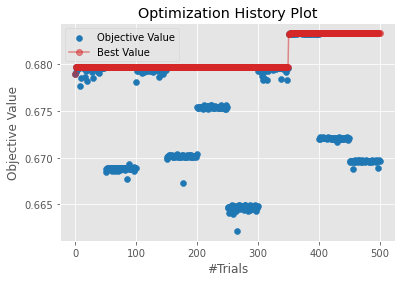

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf);

In [35]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.695561,0.042602
1,TP,165.700000,7.227263
2,TN,89.200000,6.494442
3,FP,24.200000,4.894441
4,FN,18.000000,6.446360
5,Accuracy,0.857959,0.025195
6,Precision,0.873015,0.022133
7,Sensitivity,0.902081,0.034330
8,Specificity,0.786320,0.043116
9,F1 score,0.886893,0.020808


In [36]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test['std'] = mat_met_rf_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.672213,0.730588,0.709249,0.684037,0.706921,0.706242,0.690513,0.666885,0.709272,0.716006,0.699192,0.020158
1,TP,313.000000,336.000000,319.000000,325.000000,328.000000,336.000000,326.000000,320.000000,315.000000,337.000000,325.500000,8.809717
2,TN,178.000000,174.000000,192.000000,181.000000,181.000000,181.000000,175.000000,182.000000,190.000000,173.000000,180.700000,6.325434
3,FP,59.000000,44.000000,45.000000,50.000000,49.000000,41.000000,57.000000,46.000000,54.000000,47.000000,49.200000,5.846176
4,FN,45.000000,41.000000,39.000000,39.000000,37.000000,37.000000,37.000000,47.000000,36.000000,38.000000,39.600000,3.687818
5,Accuracy,0.825210,0.857143,0.858824,0.850420,0.855462,0.868908,0.842017,0.843697,0.848739,0.857143,0.850756,0.011932
6,Precision,0.841398,0.884211,0.876374,0.866667,0.870027,0.891247,0.851175,0.874317,0.853659,0.877604,0.868668,0.015646
7,Sensitivity,0.874302,0.891247,0.891061,0.892857,0.898630,0.900804,0.898072,0.871935,0.897436,0.898667,0.891501,0.010263
8,Specificity,0.751100,0.798200,0.810100,0.783500,0.787000,0.815300,0.754300,0.798200,0.778700,0.786400,0.786280,0.021134
9,F1 score,0.857534,0.887715,0.883657,0.879567,0.884097,0.896000,0.873995,0.873124,0.875000,0.888011,0.879870,0.010661


In [37]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=8, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_rf_cat = np.where((y_pred_optimized_rf >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_run0.sort_values(by='y_test_idx0', inplace=True)
rf_run0.reset_index(inplace=True, drop=True)
rf_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_run1.sort_values(by='y_test_idx1', inplace=True)
rf_run1.reset_index(inplace=True, drop=True)
rf_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_run2.sort_values(by='y_test_idx2', inplace=True)
rf_run2.reset_index(inplace=True, drop=True)
rf_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_run3.sort_values(by='y_test_idx3', inplace=True)
rf_run3.reset_index(inplace=True, drop=True)
rf_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_run4.sort_values(by='y_test_idx4', inplace=True)
rf_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
rf_5preds = pd.concat([chembl_id, rf_run0, rf_run1, rf_run2, rf_run3, rf_run4], axis=1)
rf_5preds = rf_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds['y_pred_rf_ave'] = rf_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds['y_pred_rf_std'] = rf_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
rf_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_rf0,y_pred_rf1,y_pred_rf2,y_pred_rf3,y_pred_rf4,y_pred_rf_ave,y_pred_rf_std
0,CHEMBL356066,0,8.02,7.174476,7.267219,7.209938,7.264304,7.165649,7.350264,0.302078
1,CHEMBL3652228,1,8.05,8.153331,8.050878,8.049879,8.035496,8.023369,8.060492,0.042695
2,CHEMBL3939518,2,6.87,7.500500,7.443817,7.485595,7.504658,7.417742,7.370385,0.225925
3,CHEMBL4281792,3,7.22,8.188674,7.859492,7.526613,7.962881,7.868271,7.770989,0.314083
4,CHEMBL4070232,4,7.15,6.641647,6.772817,6.769940,6.760186,6.741241,6.805972,0.160230
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL4202521,2966,7.43,6.692375,6.812465,6.850385,6.739560,6.659054,6.863973,0.261451
2967,CHEMBL216641,2967,7.35,7.530590,7.456516,7.580243,7.486778,7.406570,7.468449,0.076045
2968,CHEMBL3693750,2968,7.43,7.415298,7.417064,7.430293,7.405985,7.412671,7.418552,0.008890
2969,CHEMBL152665,2969,5.96,6.359609,6.401652,6.463235,6.393181,6.451435,6.338185,0.172723


In [38]:
mat_met_optimized_rf

,Metric,Value (average),Value (std)
0,R2,0.696307,0.032259
1,Accuracy,0.854523,0.015821
2,Precision,0.871272,0.019052
3,Sensitivity,0.897729,0.020827
4,Specificity,0.784886,0.032495
5,F1 score,0.884051,0.013044
6,F1 score (weighted),0.853761,0.015912
7,F1 score (macro),0.844103,0.017266
8,Balanced Accuracy,0.841306,0.017698
9,MCC,0.689750,0.034577


In [39]:
rf_5preds.to_csv('rf_5test_CV_result.csv')
mat_met_optimized_rf.to_csv('mat_met_rf_opt.csv')

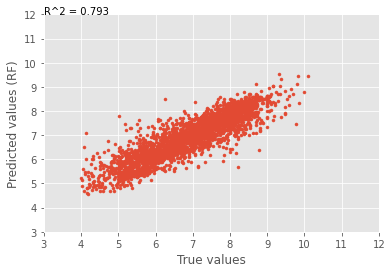

In [40]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (RF)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'])), (3, 12))
plt.show()

In [41]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_reg, X, Y, cv=10, scoring="r2")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="r2")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="r2")
print("RF baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model r2_score 0.6922 with a standard deviation of 0.0462
RF optimized model r2_score 0.6945 with a standard deviation of 0.0456


In [42]:
import joblib
joblib.dump(rf_reg, "./rf_reg.joblib")
#joblib.dump(optimized_rf, "./optimized_rf.joblib") # fitted to whole training set with last random_state selected
joblib.dump(optimizedCV_rf, "./optimizedCV_rf.joblib")

['./optimizedCV_rf.joblib']

## LGBMRegressor

In [43]:
%%time


r2_scores = np.empty(10)
TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_reg = lgbm.LGBMRegressor(
        objective="regression",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=8,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_reg.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="rmse",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_reg.predict(X_test) 
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met_lgbm = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    R2         0.694830     0.037032
1                    TP       162.300000     6.583650
2                    TN        90.300000     5.677441
3                    FP        23.100000     4.629615
4                    FN        21.400000     6.328068
5              Accuracy         0.850221     0.028696
6             Precision         0.875579     0.023610
7           Sensitivity         0.883657     0.033737
8           Specificity         0.796280     0.040199
9              F1 score         0.879304     0.023700
10  F1 score (weighted)         0.849998     0.028543
11     F1 score (macro)         0.840752     0.030373
12    Balanced Accuracy         0.839970     0.029310
13                  MCC         0.682518     0.060699
14                  NPV         0.809590     0.049992
15              ROC_AUC         0.839970     0.029310
CPU times: user 15.1 s, sys: 68 ms, total: 15.2 s
Wall time: 1.99 s


In [44]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=8,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [45]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        
    }
    
    
    
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=8,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
         # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [46]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="lgbmRegressor")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 02:39:47,404] A new study created in memory with name: lgbmRegressor
[I 2023-02-21 02:39:50,716] Trial 0 finished with value: 0.6707583877598374 and parameters: {'n_estimators': 700, 'learning_rate': 0.04523684372753985, 'max_depth': 7, 'max_bin': 171, 'num_leaves': 306}. Best is trial 0 with value: 0.6707583877598374.
[I 2023-02-21 02:39:52,911] Trial 1 finished with value: 0.6762175993721412 and parameters: {'n_estimators': 240, 'learning_rate': 0.12495239559161461, 'max_depth': 9, 'max_bin': 227, 'num_leaves': 454}. Best is trial 1 with value: 0.6762175993721412.
[I 2023-02-21 02:39:55,444] Trial 2 finished with value: 0.6820215655677535 and parameters: {'n_estimators': 745, 'learning_rate': 0.1311719079706414, 'max_depth': 9, 'max_bin': 292, 'num_leaves': 664}. Best is trial 2 with value: 0.6820215655677535.
[I 2023-02-21 02:39:57,099] Trial 3 finished with value: 0.6623311566447094 and parameters: {'n_estimators': 835, 'learning_rate': 0.14642550828077605, 'max_depth

[I 2023-02-21 02:41:36,018] Trial 31 finished with value: 0.6854954887003599 and parameters: {'n_estimators': 602, 'learning_rate': 0.05226080547044741, 'max_depth': 12, 'max_bin': 218, 'num_leaves': 44}. Best is trial 24 with value: 0.6862090103103351.
[I 2023-02-21 02:41:39,203] Trial 32 finished with value: 0.6838642768144745 and parameters: {'n_estimators': 408, 'learning_rate': 0.060505173029643755, 'max_depth': 11, 'max_bin': 235, 'num_leaves': 102}. Best is trial 24 with value: 0.6862090103103351.
[I 2023-02-21 02:41:43,589] Trial 33 finished with value: 0.6842944463980716 and parameters: {'n_estimators': 676, 'learning_rate': 0.03421623225650585, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 225}. Best is trial 24 with value: 0.6862090103103351.
[I 2023-02-21 02:41:45,812] Trial 34 finished with value: 0.6777797339600184 and parameters: {'n_estimators': 568, 'learning_rate': 0.11477082251772627, 'max_depth': 9, 'max_bin': 197, 'num_leaves': 101}. Best is trial 24 with value: 0

	Number of trials: 50.0
	Best value (r2_score): 0.6890
	Best params:
		n_estimators: 524
		learning_rate: 0.09986329043489525
		max_depth: 12
		max_bin: 228
		num_leaves: 188


In [47]:
optimized_lgbm_0 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_lgbm_0)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_0_cat = np.where((y_pred_lgbm_0>= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_lgbm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_lgbm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_lgbm_0_cat)


mat_met_lgbm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    R2    0.665689
1                    TP  314.000000
2                    TN  180.000000
3                    FP   57.000000
4                    FN   44.000000
5              Accuracy    0.830252
6             Precision    0.846361
7           Sensitivity    0.877095
8           Specificity    0.759500
9              F1 score    0.861454
10  F1 score (weighted)    0.829372
11     F1 score (macro)    0.821183
12    Balanced Accuracy    0.818294
13                  MCC    0.643226
14                  NPV    0.803600
15              ROC_AUC    0.818294


In [48]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 02:42:32,973] Trial 50 finished with value: 0.663426572710603 and parameters: {'n_estimators': 570, 'learning_rate': 0.0894808759729541, 'max_depth': 6, 'max_bin': 245, 'num_leaves': 121}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:42:36,327] Trial 51 finished with value: 0.6784029601033963 and parameters: {'n_estimators': 655, 'learning_rate': 0.06572247953466899, 'max_depth': 12, 'max_bin': 208, 'num_leaves': 168}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:42:39,380] Trial 52 finished with value: 0.6762639347984398 and parameters: {'n_estimators': 719, 'learning_rate': 0.08006960162383242, 'max_depth': 11, 'max_bin': 220, 'num_leaves': 213}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:42:42,360] Trial 53 finished with value: 0.6734983840962331 and parameters: {'n_estimators': 522, 'learning_rate': 0.10817819927483911, 'max_depth': 12, 'max_bin': 193, 'num_leaves': 271}. Best is trial 43 with value: 0.6

[I 2023-02-21 02:44:30,481] Trial 81 finished with value: 0.6552131284045654 and parameters: {'n_estimators': 421, 'learning_rate': 0.023769750049169334, 'max_depth': 8, 'max_bin': 207, 'num_leaves': 563}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:44:36,286] Trial 82 finished with value: 0.6783033935372658 and parameters: {'n_estimators': 502, 'learning_rate': 0.029342638765390745, 'max_depth': 11, 'max_bin': 214, 'num_leaves': 522}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:44:40,102] Trial 83 finished with value: 0.6735412044009159 and parameters: {'n_estimators': 582, 'learning_rate': 0.057308218938345395, 'max_depth': 10, 'max_bin': 220, 'num_leaves': 493}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:44:48,776] Trial 84 finished with value: 0.6196648958707331 and parameters: {'n_estimators': 502, 'learning_rate': 0.004529984802984437, 'max_depth': 12, 'max_bin': 217, 'num_leaves': 178}. Best is trial 43 with valu

	Number of trials: 100.0
	Best value (r2_score): 0.6890
	Best params:
		n_estimators: 524
		learning_rate: 0.09986329043489525
		max_depth: 12
		max_bin: 228
		num_leaves: 188


In [49]:
optimized_lgbm_1 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_lgbm_1)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_1_cat = np.where((y_pred_lgbm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_lgbm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_lgbm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_lgbm_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    R2    0.665689    0.729387
1                    TP  314.000000  332.000000
2                    TN  180.000000  168.000000
3                    FP   57.000000   50.000000
4                    FN   44.000000   45.000000
5              Accuracy    0.830252    0.840336
6             Precision    0.846361    0.869110
7           Sensitivity    0.877095    0.880637
8           Specificity    0.759500    0.770600
9              F1 score    0.861454    0.874835
10  F1 score (weighted)    0.829372    0.839936
11     F1 score (macro)    0.821183    0.827209
12    Balanced Accuracy    0.818294    0.825639
13                  MCC    0.643226    0.654552
14                  NPV    0.803600    0.788700
15              ROC_AUC    0.818294    0.825639


In [50]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 02:45:51,544] Trial 100 finished with value: 0.6746622513731355 and parameters: {'n_estimators': 306, 'learning_rate': 0.1115940910192676, 'max_depth': 11, 'max_bin': 278, 'num_leaves': 352}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:45:56,087] Trial 101 finished with value: 0.6754994787543072 and parameters: {'n_estimators': 591, 'learning_rate': 0.048045377859374384, 'max_depth': 11, 'max_bin': 297, 'num_leaves': 581}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:46:01,422] Trial 102 finished with value: 0.6844813006365474 and parameters: {'n_estimators': 546, 'learning_rate': 0.04208828596647454, 'max_depth': 12, 'max_bin': 254, 'num_leaves': 455}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:46:05,378] Trial 103 finished with value: 0.674803927407144 and parameters: {'n_estimators': 830, 'learning_rate': 0.055738108747720505, 'max_depth': 10, 'max_bin': 264, 'num_leaves': 431}. Best is trial 43 with val

[I 2023-02-21 02:48:05,418] Trial 131 finished with value: 0.6804114224854073 and parameters: {'n_estimators': 525, 'learning_rate': 0.05726205518638411, 'max_depth': 12, 'max_bin': 195, 'num_leaves': 337}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:48:08,485] Trial 132 finished with value: 0.6783601609252169 and parameters: {'n_estimators': 487, 'learning_rate': 0.0941201803445504, 'max_depth': 12, 'max_bin': 186, 'num_leaves': 263}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:48:12,605] Trial 133 finished with value: 0.6808870872546839 and parameters: {'n_estimators': 537, 'learning_rate': 0.05337900863707235, 'max_depth': 12, 'max_bin': 191, 'num_leaves': 300}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:48:16,573] Trial 134 finished with value: 0.6811938104978819 and parameters: {'n_estimators': 571, 'learning_rate': 0.061128601923166256, 'max_depth': 12, 'max_bin': 207, 'num_leaves': 248}. Best is trial 43 with val

	Number of trials: 150.0
	Best value (r2_score): 0.6890
	Best params:
		n_estimators: 524
		learning_rate: 0.09986329043489525
		max_depth: 12
		max_bin: 228
		num_leaves: 188


In [51]:
optimized_lgbm_2 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_lgbm_2)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_2_cat = np.where((y_pred_lgbm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_lgbm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_lgbm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_lgbm_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.665689    0.729387    0.729845
1                    TP  314.000000  332.000000  324.000000
2                    TN  180.000000  168.000000  195.000000
3                    FP   57.000000   50.000000   42.000000
4                    FN   44.000000   45.000000   34.000000
5              Accuracy    0.830252    0.840336    0.872269
6             Precision    0.846361    0.869110    0.885246
7           Sensitivity    0.877095    0.880637    0.905028
8           Specificity    0.759500    0.770600    0.822800
9              F1 score    0.861454    0.874835    0.895028
10  F1 score (weighted)    0.829372    0.839936    0.871878
11     F1 score (macro)    0.821183    0.827209    0.865969
12    Balanced Accuracy    0.818294    0.825639    0.863906
13                  MCC    0.643226    0.654552    0.732280
14                  NPV    0.803600    0.788700    0.851500
15              ROC_AUC    0.818294    0

In [52]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 02:49:26,599] Trial 150 finished with value: 0.6791068407406373 and parameters: {'n_estimators': 589, 'learning_rate': 0.09512631966654449, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 502}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:49:31,050] Trial 151 finished with value: 0.6820010527345486 and parameters: {'n_estimators': 558, 'learning_rate': 0.04174622657749043, 'max_depth': 12, 'max_bin': 254, 'num_leaves': 505}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:49:36,033] Trial 152 finished with value: 0.6843958196154005 and parameters: {'n_estimators': 564, 'learning_rate': 0.03867582058587586, 'max_depth': 12, 'max_bin': 202, 'num_leaves': 523}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:49:40,514] Trial 153 finished with value: 0.6811699046149131 and parameters: {'n_estimators': 846, 'learning_rate': 0.036031003812839996, 'max_depth': 12, 'max_bin': 201, 'num_leaves': 51}. Best is trial 43 with val

[I 2023-02-21 02:51:35,067] Trial 181 finished with value: 0.6800839027621218 and parameters: {'n_estimators': 363, 'learning_rate': 0.05430697324036963, 'max_depth': 11, 'max_bin': 239, 'num_leaves': 103}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:51:37,232] Trial 182 finished with value: 0.6529242669912996 and parameters: {'n_estimators': 390, 'learning_rate': 0.06207095268052241, 'max_depth': 5, 'max_bin': 233, 'num_leaves': 56}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:51:40,976] Trial 183 finished with value: 0.678156130635076 and parameters: {'n_estimators': 445, 'learning_rate': 0.04772243502531782, 'max_depth': 11, 'max_bin': 227, 'num_leaves': 77}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:51:44,747] Trial 184 finished with value: 0.6807479719284627 and parameters: {'n_estimators': 399, 'learning_rate': 0.05211382264266278, 'max_depth': 12, 'max_bin': 248, 'num_leaves': 127}. Best is trial 43 with value: 

	Number of trials: 200.0
	Best value (r2_score): 0.6890
	Best params:
		n_estimators: 524
		learning_rate: 0.09986329043489525
		max_depth: 12
		max_bin: 228
		num_leaves: 188


In [53]:
optimized_lgbm_3 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_lgbm_3)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_3_cat = np.where((y_pred_lgbm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_lgbm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_lgbm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_lgbm_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.665689    0.729387    0.729845    0.683805
1                    TP  314.000000  332.000000  324.000000  323.000000
2                    TN  180.000000  168.000000  195.000000  186.000000
3                    FP   57.000000   50.000000   42.000000   45.000000
4                    FN   44.000000   45.000000   34.000000   41.000000
5              Accuracy    0.830252    0.840336    0.872269    0.855462
6             Precision    0.846361    0.869110    0.885246    0.877717
7           Sensitivity    0.877095    0.880637    0.905028    0.887363
8           Specificity    0.759500    0.770600    0.822800    0.805200
9              F1 score    0.861454    0.874835    0.895028    0.882514
10  F1 score (weighted)    0.829372    0.839936    0.871878    0.855226
11     F1 score (macro)    0.821183    0.827209    0.865969    0.847370
12    Balanced Accuracy    0.818294    0.825639    0.863906    0

In [54]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 02:52:48,679] Trial 200 finished with value: 0.685995068768177 and parameters: {'n_estimators': 617, 'learning_rate': 0.05475570946855269, 'max_depth': 12, 'max_bin': 261, 'num_leaves': 587}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:52:52,733] Trial 201 finished with value: 0.6859473182037192 and parameters: {'n_estimators': 662, 'learning_rate': 0.05696594810619406, 'max_depth': 12, 'max_bin': 262, 'num_leaves': 651}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:52:57,176] Trial 202 finished with value: 0.6865856849823337 and parameters: {'n_estimators': 652, 'learning_rate': 0.05236045359891655, 'max_depth': 12, 'max_bin': 268, 'num_leaves': 646}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:53:01,046] Trial 203 finished with value: 0.6812182404658771 and parameters: {'n_estimators': 646, 'learning_rate': 0.05295762732997496, 'max_depth': 12, 'max_bin': 272, 'num_leaves': 625}. Best is trial 43 with valu

[I 2023-02-21 02:54:56,739] Trial 231 finished with value: 0.6806829562079809 and parameters: {'n_estimators': 635, 'learning_rate': 0.055237923641474056, 'max_depth': 12, 'max_bin': 278, 'num_leaves': 580}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:55:00,364] Trial 232 finished with value: 0.6824848165259096 and parameters: {'n_estimators': 650, 'learning_rate': 0.05927312666384485, 'max_depth': 12, 'max_bin': 270, 'num_leaves': 614}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:55:04,145] Trial 233 finished with value: 0.687566547496455 and parameters: {'n_estimators': 722, 'learning_rate': 0.06460965539234732, 'max_depth': 12, 'max_bin': 264, 'num_leaves': 563}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:55:07,843] Trial 234 finished with value: 0.685288645903029 and parameters: {'n_estimators': 717, 'learning_rate': 0.06431047929634509, 'max_depth': 12, 'max_bin': 267, 'num_leaves': 653}. Best is trial 43 with valu

	Number of trials: 250.0
	Best value (r2_score): 0.6890
	Best params:
		n_estimators: 524
		learning_rate: 0.09986329043489525
		max_depth: 12
		max_bin: 228
		num_leaves: 188


In [55]:
optimized_lgbm_4 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_lgbm_4)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_4_cat = np.where((y_pred_lgbm_4 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_lgbm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_lgbm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_lgbm_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665689    0.729387    0.729845    0.683805   
1                    TP  314.000000  332.000000  324.000000  323.000000   
2                    TN  180.000000  168.000000  195.000000  186.000000   
3                    FP   57.000000   50.000000   42.000000   45.000000   
4                    FN   44.000000   45.000000   34.000000   41.000000   
5              Accuracy    0.830252    0.840336    0.872269    0.855462   
6             Precision    0.846361    0.869110    0.885246    0.877717   
7           Sensitivity    0.877095    0.880637    0.905028    0.887363   
8           Specificity    0.759500    0.770600    0.822800    0.805200   
9              F1 score    0.861454    0.874835    0.895028    0.882514   
10  F1 score (weighted)    0.829372    0.839936    0.871878    0.855226   
11     F1 score (macro)    0.821183    0.827209    0.865969    0.847370   
12    Balanced Accuracy  

In [56]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 02:56:09,308] Trial 250 finished with value: 0.6673430718892026 and parameters: {'n_estimators': 750, 'learning_rate': 0.06221287221692448, 'max_depth': 12, 'max_bin': 276, 'num_leaves': 722}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:56:12,514] Trial 251 finished with value: 0.6669574287888441 and parameters: {'n_estimators': 718, 'learning_rate': 0.06762393246788131, 'max_depth': 12, 'max_bin': 271, 'num_leaves': 742}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:56:15,825] Trial 252 finished with value: 0.6687721257987581 and parameters: {'n_estimators': 710, 'learning_rate': 0.05795043373711863, 'max_depth': 12, 'max_bin': 273, 'num_leaves': 693}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:56:20,082] Trial 253 finished with value: 0.6720341943714623 and parameters: {'n_estimators': 733, 'learning_rate': 0.0607621396825651, 'max_depth': 12, 'max_bin': 282, 'num_leaves': 726}. Best is trial 43 with valu

[I 2023-02-21 02:58:01,829] Trial 281 finished with value: 0.6652871152470701 and parameters: {'n_estimators': 662, 'learning_rate': 0.06315784312031925, 'max_depth': 12, 'max_bin': 261, 'num_leaves': 607}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:58:06,246] Trial 282 finished with value: 0.6722628027781898 and parameters: {'n_estimators': 690, 'learning_rate': 0.04935053205875553, 'max_depth': 12, 'max_bin': 270, 'num_leaves': 620}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:58:09,163] Trial 283 finished with value: 0.6655259832160713 and parameters: {'n_estimators': 751, 'learning_rate': 0.09939658439812217, 'max_depth': 12, 'max_bin': 264, 'num_leaves': 574}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:58:13,215] Trial 284 finished with value: 0.670843237845755 and parameters: {'n_estimators': 726, 'learning_rate': 0.05589129415185335, 'max_depth': 12, 'max_bin': 273, 'num_leaves': 590}. Best is trial 43 with valu

	Number of trials: 300.0
	Best value (r2_score): 0.6890
	Best params:
		n_estimators: 524
		learning_rate: 0.09986329043489525
		max_depth: 12
		max_bin: 228
		num_leaves: 188


In [57]:
optimized_lgbm_5 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_lgbm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_5_cat = np.where((y_pred_lgbm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_lgbm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_lgbm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_lgbm_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665689    0.729387    0.729845    0.683805   
1                    TP  314.000000  332.000000  324.000000  323.000000   
2                    TN  180.000000  168.000000  195.000000  186.000000   
3                    FP   57.000000   50.000000   42.000000   45.000000   
4                    FN   44.000000   45.000000   34.000000   41.000000   
5              Accuracy    0.830252    0.840336    0.872269    0.855462   
6             Precision    0.846361    0.869110    0.885246    0.877717   
7           Sensitivity    0.877095    0.880637    0.905028    0.887363   
8           Specificity    0.759500    0.770600    0.822800    0.805200   
9              F1 score    0.861454    0.874835    0.895028    0.882514   
10  F1 score (weighted)    0.829372    0.839936    0.871878    0.855226   
11     F1 score (macro)    0.821183    0.827209    0.865969    0.847370   
12    Balanced Accuracy  

In [58]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 02:59:12,507] Trial 300 finished with value: 0.683366146164053 and parameters: {'n_estimators': 640, 'learning_rate': 0.09725576212564652, 'max_depth': 12, 'max_bin': 263, 'num_leaves': 167}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:59:17,303] Trial 301 finished with value: 0.681395871800866 and parameters: {'n_estimators': 660, 'learning_rate': 0.044755903118128576, 'max_depth': 12, 'max_bin': 276, 'num_leaves': 570}. Best is trial 43 with value: 0.6889680803170803.
[I 2023-02-21 02:59:21,193] Trial 302 finished with value: 0.6907864632713362 and parameters: {'n_estimators': 714, 'learning_rate': 0.07750017736109742, 'max_depth': 12, 'max_bin': 265, 'num_leaves': 732}. Best is trial 302 with value: 0.6907864632713362.
[I 2023-02-21 02:59:24,667] Trial 303 finished with value: 0.6846892432205406 and parameters: {'n_estimators': 737, 'learning_rate': 0.08925676315741368, 'max_depth': 12, 'max_bin': 261, 'num_leaves': 733}. Best is trial 302 with va

[I 2023-02-21 03:01:03,947] Trial 331 finished with value: 0.6909973218309033 and parameters: {'n_estimators': 826, 'learning_rate': 0.0784023810566808, 'max_depth': 12, 'max_bin': 161, 'num_leaves': 720}. Best is trial 331 with value: 0.6909973218309033.
[I 2023-02-21 03:01:07,003] Trial 332 finished with value: 0.6829427445877927 and parameters: {'n_estimators': 835, 'learning_rate': 0.09114124562015191, 'max_depth': 12, 'max_bin': 169, 'num_leaves': 716}. Best is trial 331 with value: 0.6909973218309033.
[I 2023-02-21 03:01:10,868] Trial 333 finished with value: 0.6839449827623705 and parameters: {'n_estimators': 808, 'learning_rate': 0.0852746294439996, 'max_depth': 12, 'max_bin': 159, 'num_leaves': 721}. Best is trial 331 with value: 0.6909973218309033.
[I 2023-02-21 03:01:14,296] Trial 334 finished with value: 0.6843251433253945 and parameters: {'n_estimators': 752, 'learning_rate': 0.07435722807700856, 'max_depth': 12, 'max_bin': 178, 'num_leaves': 749}. Best is trial 331 with v

	Number of trials: 350.0
	Best value (r2_score): 0.690997
	Best params:
		n_estimators: 826
		learning_rate: 0.0784023810566808
		max_depth: 12
		max_bin: 161
		num_leaves: 720


In [59]:
optimized_lgbm_6 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_lgbm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_6_cat = np.where((y_pred_lgbm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_lgbm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_lgbm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_lgbm_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665689    0.729387    0.729845    0.683805   
1                    TP  314.000000  332.000000  324.000000  323.000000   
2                    TN  180.000000  168.000000  195.000000  186.000000   
3                    FP   57.000000   50.000000   42.000000   45.000000   
4                    FN   44.000000   45.000000   34.000000   41.000000   
5              Accuracy    0.830252    0.840336    0.872269    0.855462   
6             Precision    0.846361    0.869110    0.885246    0.877717   
7           Sensitivity    0.877095    0.880637    0.905028    0.887363   
8           Specificity    0.759500    0.770600    0.822800    0.805200   
9              F1 score    0.861454    0.874835    0.895028    0.882514   
10  F1 score (weighted)    0.829372    0.839936    0.871878    0.855226   
11     F1 score (macro)    0.821183    0.827209    0.865969    0.847370   
12    Balanced Accuracy  

In [60]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 03:02:11,097] Trial 350 finished with value: 0.6883697664295152 and parameters: {'n_estimators': 868, 'learning_rate': 0.09062608106390874, 'max_depth': 12, 'max_bin': 164, 'num_leaves': 720}. Best is trial 331 with value: 0.6909973218309033.
[I 2023-02-21 03:02:14,582] Trial 351 finished with value: 0.690955116978368 and parameters: {'n_estimators': 869, 'learning_rate': 0.08974798452464128, 'max_depth': 12, 'max_bin': 166, 'num_leaves': 723}. Best is trial 331 with value: 0.6909973218309033.
[I 2023-02-21 03:02:17,659] Trial 352 finished with value: 0.6882128565339253 and parameters: {'n_estimators': 873, 'learning_rate': 0.09055833651224889, 'max_depth': 12, 'max_bin': 164, 'num_leaves': 726}. Best is trial 331 with value: 0.6909973218309033.
[I 2023-02-21 03:02:21,033] Trial 353 finished with value: 0.687404423667386 and parameters: {'n_estimators': 882, 'learning_rate': 0.09135735435305033, 'max_depth': 12, 'max_bin': 161, 'num_leaves': 721}. Best is trial 331 with v

[I 2023-02-21 03:03:51,181] Trial 381 finished with value: 0.6899262393760218 and parameters: {'n_estimators': 876, 'learning_rate': 0.1033354249494803, 'max_depth': 11, 'max_bin': 169, 'num_leaves': 719}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:03:54,393] Trial 382 finished with value: 0.6921698645855614 and parameters: {'n_estimators': 863, 'learning_rate': 0.10222335038704605, 'max_depth': 11, 'max_bin': 176, 'num_leaves': 675}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:03:57,410] Trial 383 finished with value: 0.6870959835940136 and parameters: {'n_estimators': 867, 'learning_rate': 0.10018963389626696, 'max_depth': 11, 'max_bin': 175, 'num_leaves': 677}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:04:00,203] Trial 384 finished with value: 0.6812278116713344 and parameters: {'n_estimators': 854, 'learning_rate': 0.10813475023009239, 'max_depth': 10, 'max_bin': 177, 'num_leaves': 695}. Best is trial 371 with val

	Number of trials: 400.0
	Best value (r2_score): 0.6934417
	Best params:
		n_estimators: 900
		learning_rate: 0.08495534562049006
		max_depth: 11
		max_bin: 169
		num_leaves: 716


In [61]:
optimized_lgbm_7 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_lgbm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_7_cat = np.where((y_pred_lgbm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_lgbm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_lgbm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_lgbm_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665689    0.729387    0.729845    0.683805   
1                    TP  314.000000  332.000000  324.000000  323.000000   
2                    TN  180.000000  168.000000  195.000000  186.000000   
3                    FP   57.000000   50.000000   42.000000   45.000000   
4                    FN   44.000000   45.000000   34.000000   41.000000   
5              Accuracy    0.830252    0.840336    0.872269    0.855462   
6             Precision    0.846361    0.869110    0.885246    0.877717   
7           Sensitivity    0.877095    0.880637    0.905028    0.887363   
8           Specificity    0.759500    0.770600    0.822800    0.805200   
9              F1 score    0.861454    0.874835    0.895028    0.882514   
10  F1 score (weighted)    0.829372    0.839936    0.871878    0.855226   
11     F1 score (macro)    0.821183    0.827209    0.865969    0.847370   
12    Balanced Accuracy  

In [62]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 03:04:46,732] Trial 400 finished with value: 0.685419083636934 and parameters: {'n_estimators': 882, 'learning_rate': 0.10358598065939557, 'max_depth': 10, 'max_bin': 170, 'num_leaves': 711}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:04:49,513] Trial 401 finished with value: 0.683520074660577 and parameters: {'n_estimators': 857, 'learning_rate': 0.106762926731263, 'max_depth': 11, 'max_bin': 166, 'num_leaves': 731}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:04:52,471] Trial 402 finished with value: 0.6893185554887626 and parameters: {'n_estimators': 841, 'learning_rate': 0.10200157240422342, 'max_depth': 11, 'max_bin': 155, 'num_leaves': 707}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:04:55,472] Trial 403 finished with value: 0.6869706793053133 and parameters: {'n_estimators': 877, 'learning_rate': 0.10335988648353667, 'max_depth': 11, 'max_bin': 162, 'num_leaves': 707}. Best is trial 371 with value:

[I 2023-02-21 03:06:20,511] Trial 431 finished with value: 0.6843207030843732 and parameters: {'n_estimators': 836, 'learning_rate': 0.09728033621181233, 'max_depth': 10, 'max_bin': 165, 'num_leaves': 706}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:06:23,714] Trial 432 finished with value: 0.6869796865957793 and parameters: {'n_estimators': 881, 'learning_rate': 0.10181609126547418, 'max_depth': 11, 'max_bin': 169, 'num_leaves': 674}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:06:27,096] Trial 433 finished with value: 0.6875893128058104 and parameters: {'n_estimators': 848, 'learning_rate': 0.08093461941076811, 'max_depth': 11, 'max_bin': 160, 'num_leaves': 691}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:06:28,558] Trial 434 finished with value: 0.6630405295983263 and parameters: {'n_estimators': 80, 'learning_rate': 0.09307930331574615, 'max_depth': 10, 'max_bin': 181, 'num_leaves': 714}. Best is trial 371 with val

	Number of trials: 450.0
	Best value (r2_score): 0.69344175
	Best params:
		n_estimators: 900
		learning_rate: 0.08495534562049006
		max_depth: 11
		max_bin: 169
		num_leaves: 716


In [63]:
optimized_lgbm_8 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_lgbm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_8_cat = np.where((y_pred_lgbm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_lgbm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_lgbm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_lgbm_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665689    0.729387    0.729845    0.683805   
1                    TP  314.000000  332.000000  324.000000  323.000000   
2                    TN  180.000000  168.000000  195.000000  186.000000   
3                    FP   57.000000   50.000000   42.000000   45.000000   
4                    FN   44.000000   45.000000   34.000000   41.000000   
5              Accuracy    0.830252    0.840336    0.872269    0.855462   
6             Precision    0.846361    0.869110    0.885246    0.877717   
7           Sensitivity    0.877095    0.880637    0.905028    0.887363   
8           Specificity    0.759500    0.770600    0.822800    0.805200   
9              F1 score    0.861454    0.874835    0.895028    0.882514   
10  F1 score (weighted)    0.829372    0.839936    0.871878    0.855226   
11     F1 score (macro)    0.821183    0.827209    0.865969    0.847370   
12    Balanced Accuracy  

In [64]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 03:07:18,559] Trial 450 finished with value: 0.6823925543789385 and parameters: {'n_estimators': 791, 'learning_rate': 0.07812289670761263, 'max_depth': 9, 'max_bin': 177, 'num_leaves': 723}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:07:21,537] Trial 451 finished with value: 0.6848797826605673 and parameters: {'n_estimators': 281, 'learning_rate': 0.08740048284687742, 'max_depth': 11, 'max_bin': 166, 'num_leaves': 737}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:07:25,110] Trial 452 finished with value: 0.6865591321880139 and parameters: {'n_estimators': 811, 'learning_rate': 0.07858096737787286, 'max_depth': 11, 'max_bin': 169, 'num_leaves': 723}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:07:27,549] Trial 453 finished with value: 0.6875880597956172 and parameters: {'n_estimators': 878, 'learning_rate': 0.1397264816297259, 'max_depth': 11, 'max_bin': 174, 'num_leaves': 712}. Best is trial 371 with valu

[I 2023-02-21 03:08:53,894] Trial 481 finished with value: 0.680377745321045 and parameters: {'n_estimators': 845, 'learning_rate': 0.10099992258450384, 'max_depth': 11, 'max_bin': 168, 'num_leaves': 711}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:08:57,015] Trial 482 finished with value: 0.6815236171350991 and parameters: {'n_estimators': 887, 'learning_rate': 0.08074496115484947, 'max_depth': 10, 'max_bin': 165, 'num_leaves': 731}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:09:00,292] Trial 483 finished with value: 0.6822569525338199 and parameters: {'n_estimators': 809, 'learning_rate': 0.09136225545819426, 'max_depth': 11, 'max_bin': 172, 'num_leaves': 683}. Best is trial 371 with value: 0.693441747718406.
[I 2023-02-21 03:09:03,167] Trial 484 finished with value: 0.6849869848193656 and parameters: {'n_estimators': 863, 'learning_rate': 0.10620554261770596, 'max_depth': 11, 'max_bin': 154, 'num_leaves': 701}. Best is trial 371 with val

	Number of trials: 500.0
	Best value (r2_score): 0.693441748
	Best params:
		n_estimators: 900
		learning_rate: 0.08495534562049006
		max_depth: 11
		max_bin: 169
		num_leaves: 716


In [65]:
optimized_lgbm_9 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_lgbm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_9_cat = np.where((y_pred_lgbm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_lgbm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_lgbm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_lgbm_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665689    0.729387    0.729845    0.683805   
1                    TP  314.000000  332.000000  324.000000  323.000000   
2                    TN  180.000000  168.000000  195.000000  186.000000   
3                    FP   57.000000   50.000000   42.000000   45.000000   
4                    FN   44.000000   45.000000   34.000000   41.000000   
5              Accuracy    0.830252    0.840336    0.872269    0.855462   
6             Precision    0.846361    0.869110    0.885246    0.877717   
7           Sensitivity    0.877095    0.880637    0.905028    0.887363   
8           Specificity    0.759500    0.770600    0.822800    0.805200   
9              F1 score    0.861454    0.874835    0.895028    0.882514   
10  F1 score (weighted)    0.829372    0.839936    0.871878    0.855226   
11     F1 score (macro)    0.821183    0.827209    0.865969    0.847370   
12    Balanced Accuracy  

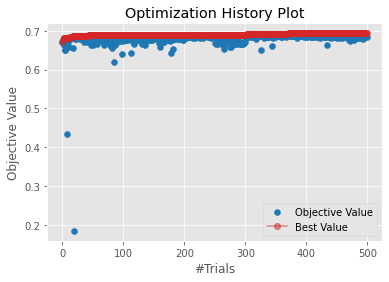

In [66]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

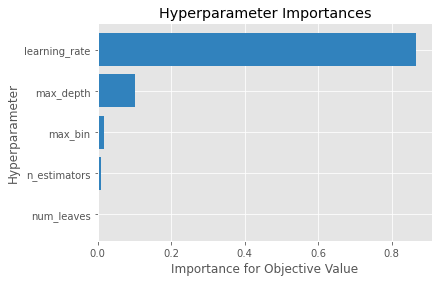

In [67]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [68]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    R2         0.705194     0.041882
1                    TP       163.300000     6.650814
2                    TN        90.700000     4.001389
3                    FP        22.700000     2.750757
4                    FN        20.400000     6.186006
5              Accuracy         0.854928     0.017799
6             Precision         0.878083     0.012896
7           Sensitivity         0.889071     0.032831
8           Specificity         0.799910     0.022451
9              F1 score         0.883169     0.015977
10  F1 score (weighted)         0.854648     0.017163
11     F1 score (macro)         0.845677     0.017831
12    Balanced Accuracy         0.844490     0.014635
13                  MCC         0.692704     0.035889
14                  NPV         0.818480     0.045044
15              ROC_AUC         0.844490     0.014635


In [69]:
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test['std'] = mat_met_lgbm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.665689,0.729387,0.729845,0.683805,0.714233,0.733553,0.700294,0.678610,0.705371,0.721373,0.706216,0.023756
1,TP,314.000000,332.000000,324.000000,323.000000,329.000000,329.000000,323.000000,315.000000,309.000000,332.000000,323.000000,8.000000
2,TN,180.000000,168.000000,195.000000,186.000000,185.000000,187.000000,169.000000,184.000000,191.000000,170.000000,181.500000,9.513149
3,FP,57.000000,50.000000,42.000000,45.000000,45.000000,35.000000,63.000000,44.000000,53.000000,50.000000,48.400000,8.002777
4,FN,44.000000,45.000000,34.000000,41.000000,36.000000,44.000000,40.000000,52.000000,42.000000,43.000000,42.100000,4.976612
5,Accuracy,0.830252,0.840336,0.872269,0.855462,0.863866,0.867227,0.826891,0.838655,0.840336,0.843697,0.847899,0.015811
6,Precision,0.846361,0.869110,0.885246,0.877717,0.879679,0.903846,0.836788,0.877437,0.853591,0.869110,0.869889,0.019774
7,Sensitivity,0.877095,0.880637,0.905028,0.887363,0.901370,0.882038,0.889807,0.858311,0.880342,0.885333,0.884732,0.013002
8,Specificity,0.759500,0.770600,0.822800,0.805200,0.804300,0.842300,0.728400,0.807000,0.782800,0.772700,0.789560,0.033310
9,F1 score,0.861454,0.874835,0.895028,0.882514,0.890392,0.892809,0.862483,0.867769,0.866760,0.877147,0.877119,0.012613


In [70]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where((y_pred_optimized_lgbm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_run0.reset_index(inplace=True, drop=True)
lgbm_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_run1.reset_index(inplace=True, drop=True)
lgbm_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_run2.reset_index(inplace=True, drop=True)
lgbm_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_run3.reset_index(inplace=True, drop=True)
lgbm_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
lgbm_5preds = pd.concat([chembl_id, lgbm_run0, lgbm_run1, lgbm_run2, lgbm_run3, lgbm_run4], axis=1)
lgbm_5preds = lgbm_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds['y_pred_lgbm_ave'] = lgbm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds['y_pred_lgbm_std'] = lgbm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
lgbm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_lgbm0,y_pred_lgbm1,y_pred_lgbm2,y_pred_lgbm3,y_pred_lgbm4,y_pred_lgbm_ave,y_pred_lgbm_std
0,CHEMBL356066,0,8.02,7.027552,6.994031,7.679035,7.172198,7.084122,7.329490,0.384628
1,CHEMBL3652228,1,8.05,8.039660,7.974594,7.963269,7.993696,7.979001,8.000037,0.033036
2,CHEMBL3939518,2,6.87,7.045209,7.017585,7.267522,7.224131,7.060251,7.080783,0.132621
3,CHEMBL4281792,3,7.22,8.295245,7.772152,7.460480,7.994341,7.864734,7.767825,0.349634
4,CHEMBL4070232,4,7.15,6.248655,6.406398,6.466830,6.340835,6.302526,6.485874,0.305142
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL4202521,2966,7.43,6.972672,6.848559,7.107165,7.115588,7.112335,7.097720,0.177365
2967,CHEMBL216641,2967,7.35,7.330716,6.786085,7.129787,7.115661,7.422361,7.189102,0.212794
2968,CHEMBL3693750,2968,7.43,7.561387,7.460591,7.490798,7.648749,7.615294,7.534470,0.080204
2969,CHEMBL152665,2969,5.96,6.489407,6.276246,6.501565,6.342075,6.105291,6.279097,0.195673


In [71]:
mat_met_optimized_lgbm.to_csv('mat_met_lgbm_opt.csv')
lgbm_5preds.to_csv('lgbm_5test_CV_result.csv')

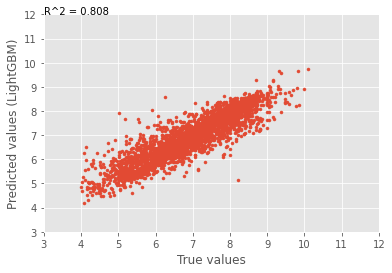

In [72]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'])), (3, 12))
plt.show()

In [73]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_reg, X, Y, cv=10, scoring="r2")
#r2_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="r2")
r2_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="r2", fit_params=fit_params)
print("LightGBM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)r2_score %0.4f with a standard deviation of %0.4f" % (r2_cv_lgbm_opt_testSet.mean(), r2_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(r2_cv_lgbm_opt), np.std(r2_cv_lgbm_opt, ddof=1)))

LightGBM baseline model r2_score 0.6870 with a standard deviation of 0.0402
LightGBM optimized model r2_score 0.6978 with a standard deviation of 0.0398


In [74]:
joblib.dump(lgbm_reg, "./lgbm_reg.joblib")
#joblib.dump(optimized_lgbm, "./optimized_lgbm.joblib")
joblib.dump(optimizedCV_lgbm, "./optimizedCV_lgbm.joblib") 
#loaded_rf = joblib.load("./optimized_rf.joblib")

['./optimizedCV_lgbm.joblib']

## XGBoost

In [75]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_reg.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores),np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.662865     0.044659
1                    TP       162.200000     5.808040
2                    TN        87.700000     5.538752
3                    FP        25.700000     3.433495
4                    FN        21.500000     5.700877
5              Accuracy         0.841132     0.022316
6             Precision         0.863380     0.016355
7           Sensitivity         0.883143     0.029800
8           Specificity         0.773040     0.032204
9              F1 score         0.872897     0.018306
10  F1 score (weighted)         0.840527     0.021972
11     F1 score (macro)         0.830275     0.023931
12    Balanced Accuracy         0.828093     0.022616
13                  MCC         0.661775     0.047727
14                  NPV         0.804110     0.043988
15              ROC_AUC         0.828093     0.022616
CPU times: user 57.8 s, sys: 144 ms, total: 57.9 s
Wall time: 1.95 s


In [76]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=8, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
            
    return np.mean(cv_scores)

In [77]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=8, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [78]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBRegressor")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 03:10:49,485] A new study created in memory with name: XGBRegressor
[I 2023-02-21 03:10:57,085] Trial 0 finished with value: 0.6887606553467972 and parameters: {'n_estimators': 556, 'eta': 0.06090927343192556, 'max_depth': 7, 'alpha': 0.9495, 'lambda': 4.150146102913757, 'max_bin': 367}. Best is trial 0 with value: 0.6887606553467972.
[I 2023-02-21 03:11:01,589] Trial 1 finished with value: 0.674115205876621 and parameters: {'n_estimators': 157, 'eta': 0.06874298517611252, 'max_depth': 10, 'alpha': 0.525, 'lambda': 24.11514418522569, 'max_bin': 254}. Best is trial 0 with value: 0.6887606553467972.
[I 2023-02-21 03:11:16,362] Trial 2 finished with value: 0.671304516793783 and parameters: {'n_estimators': 698, 'eta': 0.009944054838148492, 'max_depth': 8, 'alpha': 0.4535, 'lambda': 2.1661046817828793, 'max_bin': 355}. Best is trial 0 with value: 0.6887606553467972.
[I 2023-02-21 03:11:28,294] Trial 3 finished with value: 0.6854489472980386 and parameters: {'n_estimators': 42

[I 2023-02-21 03:16:28,910] Trial 29 finished with value: 0.6880330775781932 and parameters: {'n_estimators': 560, 'eta': 0.05860116552518734, 'max_depth': 7, 'alpha': 0.9313, 'lambda': 27.593319353043785, 'max_bin': 343}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:16:41,960] Trial 30 finished with value: 0.6872716847397677 and parameters: {'n_estimators': 420, 'eta': 0.04969994409280595, 'max_depth': 11, 'alpha': 0.49360000000000004, 'lambda': 32.53003789974839, 'max_bin': 407}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:16:54,743] Trial 31 finished with value: 0.6902844083645432 and parameters: {'n_estimators': 820, 'eta': 0.05617221999712053, 'max_depth': 8, 'alpha': 0.8931, 'lambda': 28.642365307472236, 'max_bin': 442}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:17:11,319] Trial 32 finished with value: 0.6899766787524524 and parameters: {'n_estimators': 840, 'eta': 0.03343235237921502, 'max_depth': 8, 'alpha': 0.7

	Number of trials: 50.0
	Best value (r2_score): 0.6935
	Best params:
		n_estimators: 823
		eta: 0.03609266086019035
		max_depth: 8
		alpha: 0.8882
		lambda: 34.0192867736503
		max_bin: 462


In [79]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

    # r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_xgb_0)
y_pred_xgb_0_cat = np.where((y_pred_xgb_0 >= 6.6), 1, 0)
    #calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_xgb_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_xgb_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_xgb_0_cat)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    R2    0.684712
1                    TP  314.000000
2                    TN  184.000000
3                    FP   53.000000
4                    FN   44.000000
5              Accuracy    0.836975
6             Precision    0.855586
7           Sensitivity    0.877095
8           Specificity    0.776400
9              F1 score    0.866207
10  F1 score (weighted)    0.836409
11     F1 score (macro)    0.828802
12    Balanced Accuracy    0.826733
13                  MCC    0.658019
14                  NPV    0.807000
15              ROC_AUC    0.826733


In [80]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 03:20:59,620] Trial 50 finished with value: 0.6821483230457794 and parameters: {'n_estimators': 750, 'eta': 0.0751575649766919, 'max_depth': 9, 'alpha': 0.7603000000000001, 'lambda': 34.49400410663728, 'max_bin': 277}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:21:13,530] Trial 51 finished with value: 0.683271281527716 and parameters: {'n_estimators': 843, 'eta': 0.054199632705991756, 'max_depth': 8, 'alpha': 0.6944, 'lambda': 27.34477664148404, 'max_bin': 442}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:21:29,283] Trial 52 finished with value: 0.6792667223808357 and parameters: {'n_estimators': 799, 'eta': 0.03708038642065492, 'max_depth': 8, 'alpha': 0.8278000000000001, 'lambda': 29.45987537631089, 'max_bin': 415}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:21:44,599] Trial 53 finished with value: 0.6836177075856209 and parameters: {'n_estimators': 866, 'eta': 0.044977337237953975, 'max_depth': 8, 'alp

[I 2023-02-21 03:27:05,735] Trial 79 finished with value: 0.6807117742269896 and parameters: {'n_estimators': 850, 'eta': 0.04666580676586686, 'max_depth': 9, 'alpha': 0.2159, 'lambda': 28.383651669831522, 'max_bin': 351}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:27:28,052] Trial 80 finished with value: 0.6825180938074769 and parameters: {'n_estimators': 875, 'eta': 0.0297903950010681, 'max_depth': 11, 'alpha': 0.8148000000000001, 'lambda': 29.602130958451724, 'max_bin': 455}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:27:40,866] Trial 81 finished with value: 0.6788727336321808 and parameters: {'n_estimators': 877, 'eta': 0.035576096414033295, 'max_depth': 9, 'alpha': 0.44020000000000004, 'lambda': 1.2390782417734023, 'max_bin': 410}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:28:00,683] Trial 82 finished with value: 0.6805042274850763 and parameters: {'n_estimators': 899, 'eta': 0.031857530811584156, 'max_depth': 9

	Number of trials: 100.0
	Best value (r2_score): 0.6935
	Best params:
		n_estimators: 823
		eta: 0.03609266086019035
		max_depth: 8
		alpha: 0.8882
		lambda: 34.0192867736503
		max_bin: 462


In [81]:
optimized_xgb_1 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_xgb_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_1_cat = np.where((y_pred_xgb_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_xgb_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_xgb_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_xgb_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    R2    0.684712    0.733307
1                    TP  314.000000  332.000000
2                    TN  184.000000  177.000000
3                    FP   53.000000   41.000000
4                    FN   44.000000   45.000000
5              Accuracy    0.836975    0.855462
6             Precision    0.855586    0.890080
7           Sensitivity    0.877095    0.880637
8           Specificity    0.776400    0.811900
9              F1 score    0.866207    0.885333
10  F1 score (weighted)    0.836409    0.855734
11     F1 score (macro)    0.828802    0.844939
12    Balanced Accuracy    0.826733    0.846282
13                  MCC    0.658019    0.689966
14                  NPV    0.807000    0.797300
15              ROC_AUC    0.826733    0.846282


In [82]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 03:32:30,325] Trial 100 finished with value: 0.6933756200301825 and parameters: {'n_estimators': 863, 'eta': 0.04939059069821651, 'max_depth': 8, 'alpha': 0.9466, 'lambda': 22.962584944253337, 'max_bin': 394}. Best is trial 19 with value: 0.6935245480924468.
[I 2023-02-21 03:32:47,082] Trial 101 finished with value: 0.6955126623367652 and parameters: {'n_estimators': 854, 'eta': 0.04308318865959443, 'max_depth': 8, 'alpha': 0.9506, 'lambda': 22.691672811930044, 'max_bin': 395}. Best is trial 101 with value: 0.6955126623367652.
[I 2023-02-21 03:33:03,188] Trial 102 finished with value: 0.692536170895372 and parameters: {'n_estimators': 854, 'eta': 0.04531239430052874, 'max_depth': 8, 'alpha': 0.8944000000000001, 'lambda': 18.522682921392033, 'max_bin': 410}. Best is trial 101 with value: 0.6955126623367652.
[I 2023-02-21 03:33:19,237] Trial 103 finished with value: 0.693432697784413 and parameters: {'n_estimators': 855, 'eta': 0.04538448327436697, 'max_depth': 8, 'alpha': 

[I 2023-02-21 03:40:13,705] Trial 129 finished with value: 0.6925970746865386 and parameters: {'n_estimators': 839, 'eta': 0.04042232953187772, 'max_depth': 7, 'alpha': 0.9460000000000001, 'lambda': 13.907718799114857, 'max_bin': 482}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:40:27,665] Trial 130 finished with value: 0.6932380711095119 and parameters: {'n_estimators': 899, 'eta': 0.05499011732053737, 'max_depth': 7, 'alpha': 0.9715, 'lambda': 24.173279597718114, 'max_bin': 489}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:40:43,882] Trial 131 finished with value: 0.6927030763610282 and parameters: {'n_estimators': 866, 'eta': 0.045370177442478676, 'max_depth': 8, 'alpha': 0.8825000000000001, 'lambda': 17.52549254860841, 'max_bin': 479}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:40:59,493] Trial 132 finished with value: 0.6933313397062191 and parameters: {'n_estimators': 873, 'eta': 0.05039223682416485, 'max_depth

	Number of trials: 150.0
	Best value (r2_score): 0.6973
	Best params:
		n_estimators: 869
		eta: 0.04617477429928047
		max_depth: 8
		alpha: 0.8785000000000001
		lambda: 17.514476657462126
		max_bin: 479


In [83]:
optimized_xgb_2 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_xgb_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_2_cat = np.where((y_pred_xgb_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_xgb_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_xgb_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_xgb_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.684712    0.733307    0.708160
1                    TP  314.000000  332.000000  320.000000
2                    TN  184.000000  177.000000  187.000000
3                    FP   53.000000   41.000000   50.000000
4                    FN   44.000000   45.000000   38.000000
5              Accuracy    0.836975    0.855462    0.852101
6             Precision    0.855586    0.890080    0.864865
7           Sensitivity    0.877095    0.880637    0.893855
8           Specificity    0.776400    0.811900    0.789000
9              F1 score    0.866207    0.885333    0.879121
10  F1 score (weighted)    0.836409    0.855734    0.851399
11     F1 score (macro)    0.828802    0.844939    0.844322
12    Balanced Accuracy    0.826733    0.846282    0.841442
13                  MCC    0.658019    0.689966    0.689399
14                  NPV    0.807000    0.797300    0.831100
15              ROC_AUC    0.826733    0

In [84]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 03:45:40,360] Trial 150 finished with value: 0.6828814671389879 and parameters: {'n_estimators': 786, 'eta': 0.05854950493132243, 'max_depth': 8, 'alpha': 0.8345, 'lambda': 20.552176470906026, 'max_bin': 459}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:45:53,966] Trial 151 finished with value: 0.6845209460747055 and parameters: {'n_estimators': 783, 'eta': 0.05228606092060687, 'max_depth': 8, 'alpha': 0.8666, 'lambda': 20.88448050496823, 'max_bin': 453}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:46:05,776] Trial 152 finished with value: 0.6786949605162145 and parameters: {'n_estimators': 749, 'eta': 0.051789366154700686, 'max_depth': 8, 'alpha': 0.8424, 'lambda': 19.606783773596582, 'max_bin': 447}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:46:18,144] Trial 153 finished with value: 0.6828167280597635 and parameters: {'n_estimators': 817, 'eta': 0.05669258151991975, 'max_depth': 8, 'alpha': 0.8167000

[I 2023-02-21 03:51:42,597] Trial 179 finished with value: 0.6826804004581949 and parameters: {'n_estimators': 816, 'eta': 0.04577156515176119, 'max_depth': 8, 'alpha': 0.9091, 'lambda': 20.679685314238377, 'max_bin': 476}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:51:55,969] Trial 180 finished with value: 0.6857161755441853 and parameters: {'n_estimators': 757, 'eta': 0.04872110045531806, 'max_depth': 8, 'alpha': 0.9502, 'lambda': 17.968310144731433, 'max_bin': 493}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:52:05,858] Trial 181 finished with value: 0.6795272810535382 and parameters: {'n_estimators': 475, 'eta': 0.04353647461901762, 'max_depth': 8, 'alpha': 0.9249, 'lambda': 21.497890458736144, 'max_bin': 481}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:52:18,827] Trial 182 finished with value: 0.6829846189338087 and parameters: {'n_estimators': 898, 'eta': 0.044455243972767934, 'max_depth': 8, 'alpha': 0.873300

	Number of trials: 200.0
	Best value (r2_score): 0.6973
	Best params:
		n_estimators: 869
		eta: 0.04617477429928047
		max_depth: 8
		alpha: 0.8785000000000001
		lambda: 17.514476657462126
		max_bin: 479


In [85]:
optimized_xgb_3 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_xgb_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_3_cat = np.where((y_pred_xgb_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_xgb_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_xgb_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_xgb_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.684712    0.733307    0.708160    0.688529
1                    TP  314.000000  332.000000  320.000000  321.000000
2                    TN  184.000000  177.000000  187.000000  180.000000
3                    FP   53.000000   41.000000   50.000000   51.000000
4                    FN   44.000000   45.000000   38.000000   43.000000
5              Accuracy    0.836975    0.855462    0.852101    0.842017
6             Precision    0.855586    0.890080    0.864865    0.862903
7           Sensitivity    0.877095    0.880637    0.893855    0.881868
8           Specificity    0.776400    0.811900    0.789000    0.779200
9              F1 score    0.866207    0.885333    0.879121    0.872283
10  F1 score (weighted)    0.836409    0.855734    0.851399    0.841483
11     F1 score (macro)    0.828802    0.844939    0.844322    0.832617
12    Balanced Accuracy    0.826733    0.846282    0.841442    0

In [86]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 03:55:54,921] Trial 200 finished with value: 0.6884615541293856 and parameters: {'n_estimators': 848, 'eta': 0.0481598781792154, 'max_depth': 8, 'alpha': 0.8706, 'lambda': 21.825943136612125, 'max_bin': 441}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:56:08,112] Trial 201 finished with value: 0.6900726826512786 and parameters: {'n_estimators': 860, 'eta': 0.044854802209268005, 'max_depth': 8, 'alpha': 0.9363, 'lambda': 19.069574627595596, 'max_bin': 449}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:56:20,444] Trial 202 finished with value: 0.6902012268298068 and parameters: {'n_estimators': 834, 'eta': 0.05196272888132909, 'max_depth': 8, 'alpha': 0.8996000000000001, 'lambda': 19.60754467531184, 'max_bin': 443}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 03:56:32,705] Trial 203 finished with value: 0.6899369211704147 and parameters: {'n_estimators': 884, 'eta': 0.04608189007216606, 'max_depth': 8, 'alpha'

[I 2023-02-21 04:02:00,175] Trial 229 finished with value: 0.6896649582637908 and parameters: {'n_estimators': 804, 'eta': 0.04189002174699714, 'max_depth': 8, 'alpha': 0.9071, 'lambda': 20.318154329030936, 'max_bin': 453}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:02:11,270] Trial 230 finished with value: 0.6911342124663684 and parameters: {'n_estimators': 886, 'eta': 0.055756959087967684, 'max_depth': 8, 'alpha': 0.883, 'lambda': 22.577147851726764, 'max_bin': 460}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:02:23,189] Trial 231 finished with value: 0.6889457110020485 and parameters: {'n_estimators': 869, 'eta': 0.051240497343082586, 'max_depth': 8, 'alpha': 0.9133, 'lambda': 15.437396159017014, 'max_bin': 473}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:02:34,555] Trial 232 finished with value: 0.6905158570439678 and parameters: {'n_estimators': 867, 'eta': 0.04970810259010618, 'max_depth': 8, 'alpha': 0.9494, 

	Number of trials: 250.0
	Best value (r2_score): 0.6973
	Best params:
		n_estimators: 869
		eta: 0.04617477429928047
		max_depth: 8
		alpha: 0.8785000000000001
		lambda: 17.514476657462126
		max_bin: 479


In [87]:
optimized_xgb_4 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_xgb_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_4_cat = np.where((y_pred_xgb_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_xgb_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_xgb_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_xgb_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.684712    0.733307    0.708160    0.688529   
1                    TP  314.000000  332.000000  320.000000  321.000000   
2                    TN  184.000000  177.000000  187.000000  180.000000   
3                    FP   53.000000   41.000000   50.000000   51.000000   
4                    FN   44.000000   45.000000   38.000000   43.000000   
5              Accuracy    0.836975    0.855462    0.852101    0.842017   
6             Precision    0.855586    0.890080    0.864865    0.862903   
7           Sensitivity    0.877095    0.880637    0.893855    0.881868   
8           Specificity    0.776400    0.811900    0.789000    0.779200   
9              F1 score    0.866207    0.885333    0.879121    0.872283   
10  F1 score (weighted)    0.836409    0.855734    0.851399    0.841483   
11     F1 score (macro)    0.828802    0.844939    0.844322    0.832617   
12    Balanced Accuracy  

In [88]:
len(y_pred_xgb_4_cat)

595

In [89]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:06:17,717] Trial 250 finished with value: 0.6761223140913089 and parameters: {'n_estimators': 789, 'eta': 0.05840916367374552, 'max_depth': 8, 'alpha': 0.8934000000000001, 'lambda': 21.315734101397926, 'max_bin': 487}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:06:32,770] Trial 251 finished with value: 0.6744999439515248 and parameters: {'n_estimators': 857, 'eta': 0.04433218656038, 'max_depth': 8, 'alpha': 0.8716, 'lambda': 19.411763082839954, 'max_bin': 454}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:06:40,497] Trial 252 finished with value: -2.337052722352459 and parameters: {'n_estimators': 838, 'eta': 0.0015473160827854174, 'max_depth': 8, 'alpha': 0.9168000000000001, 'lambda': 22.95503508609185, 'max_bin': 479}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:06:54,175] Trial 253 finished with value: 0.6743388992566163 and parameters: {'n_estimators': 802, 'eta': 0.04658519442172134, 'max_depth':

[I 2023-02-21 04:12:58,624] Trial 279 finished with value: 0.6785395317466997 and parameters: {'n_estimators': 788, 'eta': 0.04202893516383133, 'max_depth': 8, 'alpha': 0.8804000000000001, 'lambda': 20.61468656613419, 'max_bin': 439}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:13:05,853] Trial 280 finished with value: 0.6710019006685595 and parameters: {'n_estimators': 840, 'eta': 0.09926527611776612, 'max_depth': 7, 'alpha': 0.9343, 'lambda': 22.8902246601114, 'max_bin': 405}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:13:21,058] Trial 281 finished with value: 0.6773835962319523 and parameters: {'n_estimators': 818, 'eta': 0.039727209896350764, 'max_depth': 8, 'alpha': 0.8273, 'lambda': 17.6747119266396, 'max_bin': 473}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:13:34,871] Trial 282 finished with value: 0.6741118894922876 and parameters: {'n_estimators': 866, 'eta': 0.04378352048097352, 'max_depth': 8, 'alpha': 0

	Number of trials: 300.0
	Best value (r2_score): 0.6973
	Best params:
		n_estimators: 869
		eta: 0.04617477429928047
		max_depth: 8
		alpha: 0.8785000000000001
		lambda: 17.514476657462126
		max_bin: 479


In [90]:
optimized_xgb_5 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_xgb_5)
# now convert the resuls to binary with cutoff 6.5

y_pred_xgb_5_cat = np.where((y_pred_xgb_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_xgb_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_xgb_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_xgb_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.684712    0.733307    0.708160    0.688529   
1                    TP  314.000000  332.000000  320.000000  321.000000   
2                    TN  184.000000  177.000000  187.000000  180.000000   
3                    FP   53.000000   41.000000   50.000000   51.000000   
4                    FN   44.000000   45.000000   38.000000   43.000000   
5              Accuracy    0.836975    0.855462    0.852101    0.842017   
6             Precision    0.855586    0.890080    0.864865    0.862903   
7           Sensitivity    0.877095    0.880637    0.893855    0.881868   
8           Specificity    0.776400    0.811900    0.789000    0.779200   
9              F1 score    0.866207    0.885333    0.879121    0.872283   
10  F1 score (weighted)    0.836409    0.855734    0.851399    0.841483   
11     F1 score (macro)    0.828802    0.844939    0.844322    0.832617   
12    Balanced Accuracy  

In [91]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:17:33,509] Trial 300 finished with value: 0.6964480494524439 and parameters: {'n_estimators': 801, 'eta': 0.052056845083922804, 'max_depth': 7, 'alpha': 0.1213, 'lambda': 23.14309738324572, 'max_bin': 431}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:17:47,185] Trial 301 finished with value: 0.6948495367922202 and parameters: {'n_estimators': 798, 'eta': 0.05275569809452932, 'max_depth': 7, 'alpha': 0.3356, 'lambda': 24.192918764322016, 'max_bin': 436}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:17:59,750] Trial 302 finished with value: 0.6956275577684201 and parameters: {'n_estimators': 776, 'eta': 0.05279109907807509, 'max_depth': 7, 'alpha': 0.2265, 'lambda': 23.40602450058991, 'max_bin': 431}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:18:11,053] Trial 303 finished with value: 0.6908256078278546 and parameters: {'n_estimators': 794, 'eta': 0.05690349495846777, 'max_depth': 7, 'alpha': 0.1087, 'l

[I 2023-02-21 04:23:32,799] Trial 329 finished with value: 0.6945773580119723 and parameters: {'n_estimators': 727, 'eta': 0.06137791519251653, 'max_depth': 7, 'alpha': 0.28090000000000004, 'lambda': 28.137617954591057, 'max_bin': 412}. Best is trial 124 with value: 0.6972549107298986.
[I 2023-02-21 04:23:44,908] Trial 330 finished with value: 0.6973610577578825 and parameters: {'n_estimators': 676, 'eta': 0.0664486518754298, 'max_depth': 7, 'alpha': 0.26890000000000003, 'lambda': 28.387879494762064, 'max_bin': 426}. Best is trial 330 with value: 0.6973610577578825.
[I 2023-02-21 04:23:55,739] Trial 331 finished with value: 0.6932182279502431 and parameters: {'n_estimators': 680, 'eta': 0.06636454251132855, 'max_depth': 7, 'alpha': 0.2778, 'lambda': 27.447084953271734, 'max_bin': 422}. Best is trial 330 with value: 0.6973610577578825.
[I 2023-02-21 04:24:08,404] Trial 332 finished with value: 0.6947732699080666 and parameters: {'n_estimators': 724, 'eta': 0.06132831345990185, 'max_dept

	Number of trials: 350.0
	Best value (r2_score): 0.6987
	Best params:
		n_estimators: 664
		eta: 0.07661568123004531
		max_depth: 7
		alpha: 0.33590000000000003
		lambda: 30.08089368243512
		max_bin: 398


In [92]:
optimized_xgb_6 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_xgb_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_6_cat = np.where((y_pred_xgb_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_xgb_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_xgb_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_xgb_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.684712    0.733307    0.708160    0.688529   
1                    TP  314.000000  332.000000  320.000000  321.000000   
2                    TN  184.000000  177.000000  187.000000  180.000000   
3                    FP   53.000000   41.000000   50.000000   51.000000   
4                    FN   44.000000   45.000000   38.000000   43.000000   
5              Accuracy    0.836975    0.855462    0.852101    0.842017   
6             Precision    0.855586    0.890080    0.864865    0.862903   
7           Sensitivity    0.877095    0.880637    0.893855    0.881868   
8           Specificity    0.776400    0.811900    0.789000    0.779200   
9              F1 score    0.866207    0.885333    0.879121    0.872283   
10  F1 score (weighted)    0.836409    0.855734    0.851399    0.841483   
11     F1 score (macro)    0.828802    0.844939    0.844322    0.832617   
12    Balanced Accuracy  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:27:24,162] Trial 350 finished with value: 0.6903695909291098 and parameters: {'n_estimators': 667, 'eta': 0.08208362508524658, 'max_depth': 7, 'alpha': 0.2913, 'lambda': 29.60648877869309, 'max_bin': 400}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:27:34,297] Trial 351 finished with value: 0.6915233015173616 and parameters: {'n_estimators': 644, 'eta': 0.07383249134660519, 'max_depth': 7, 'alpha': 0.3316, 'lambda': 29.8540758359935, 'max_bin': 392}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:27:44,536] Trial 352 finished with value: 0.6941546278913797 and parameters: {'n_estimators': 670, 'eta': 0.07919523684775641, 'max_depth': 7, 'alpha': 0.2146, 'lambda': 31.021973230270554, 'max_bin': 402}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:27:54,984] Trial 353 finished with value: 0.6932967834325426 and parameters: {'n_estimators': 653, 'eta': 0.07186351303057588, 'max_depth': 7, 'alpha': 0.3054, 'lam

[I 2023-02-21 04:32:11,773] Trial 379 finished with value: 0.689481200157547 and parameters: {'n_estimators': 642, 'eta': 0.07521569855776752, 'max_depth': 7, 'alpha': 0.1153, 'lambda': 27.045371155915063, 'max_bin': 432}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:32:22,287] Trial 380 finished with value: 0.69419995109283 and parameters: {'n_estimators': 708, 'eta': 0.0788300648484258, 'max_depth': 7, 'alpha': 0.3675, 'lambda': 31.58980327524169, 'max_bin': 399}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:32:33,358] Trial 381 finished with value: 0.6929038321796217 and parameters: {'n_estimators': 737, 'eta': 0.06498675784593108, 'max_depth': 7, 'alpha': 0.2912, 'lambda': 28.88237947699082, 'max_bin': 415}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:32:43,970] Trial 382 finished with value: 0.6928704897513047 and parameters: {'n_estimators': 670, 'eta': 0.07019598185559744, 'max_depth': 7, 'alpha': 0.2714000000000

	Number of trials: 400.0
	Best value (r2_score): 0.6987
	Best params:
		n_estimators: 664
		eta: 0.07661568123004531
		max_depth: 7
		alpha: 0.33590000000000003
		lambda: 30.08089368243512
		max_bin: 398


In [94]:
optimized_xgb_7 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_xgb_7)
# now convert the resuls to binary with cutoff 6.7
y_pred_xgb_7_cat = np.where((y_pred_xgb_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_xgb_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_xgb_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_xgb_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.684712    0.733307    0.708160    0.688529   
1                    TP  314.000000  332.000000  320.000000  321.000000   
2                    TN  184.000000  177.000000  187.000000  180.000000   
3                    FP   53.000000   41.000000   50.000000   51.000000   
4                    FN   44.000000   45.000000   38.000000   43.000000   
5              Accuracy    0.836975    0.855462    0.852101    0.842017   
6             Precision    0.855586    0.890080    0.864865    0.862903   
7           Sensitivity    0.877095    0.880637    0.893855    0.881868   
8           Specificity    0.776400    0.811900    0.789000    0.779200   
9              F1 score    0.866207    0.885333    0.879121    0.872283   
10  F1 score (weighted)    0.836409    0.855734    0.851399    0.841483   
11     F1 score (macro)    0.828802    0.844939    0.844322    0.832617   
12    Balanced Accuracy  

In [95]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:35:44,762] Trial 400 finished with value: 0.6885007633285096 and parameters: {'n_estimators': 676, 'eta': 0.060155672648433106, 'max_depth': 7, 'alpha': 0.2777, 'lambda': 28.65541007425871, 'max_bin': 426}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:35:54,699] Trial 401 finished with value: 0.687483566184936 and parameters: {'n_estimators': 698, 'eta': 0.07062753414878953, 'max_depth': 7, 'alpha': 0.24760000000000001, 'lambda': 30.92961608368772, 'max_bin': 401}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:36:03,423] Trial 402 finished with value: 0.6861676965842913 and parameters: {'n_estimators': 755, 'eta': 0.08070195615762384, 'max_depth': 7, 'alpha': 0.2258, 'lambda': 25.504238322443623, 'max_bin': 412}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:36:14,660] Trial 403 finished with value: 0.6909309167571094 and parameters: {'n_estimators': 660, 'eta': 0.06834570985530732, 'max_depth': 7, 'alpha'

[I 2023-02-21 04:40:35,652] Trial 429 finished with value: 0.684661861622572 and parameters: {'n_estimators': 696, 'eta': 0.05554751023763539, 'max_depth': 12, 'alpha': 0.14500000000000002, 'lambda': 29.307345742988243, 'max_bin': 428}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:40:46,332] Trial 430 finished with value: 0.6896085599053581 and parameters: {'n_estimators': 609, 'eta': 0.06197005887394587, 'max_depth': 7, 'alpha': 0.1163, 'lambda': 30.030465449960012, 'max_bin': 376}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:40:56,280] Trial 431 finished with value: 0.69028380192158 and parameters: {'n_estimators': 780, 'eta': 0.07974010673831894, 'max_depth': 7, 'alpha': 0.1794, 'lambda': 27.174965394819594, 'max_bin': 396}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:41:07,020] Trial 432 finished with value: 0.6908360940602283 and parameters: {'n_estimators': 663, 'eta': 0.06616106726428442, 'max_depth': 7, 'alpha'

	Number of trials: 450.0
	Best value (r2_score): 0.6987
	Best params:
		n_estimators: 664
		eta: 0.07661568123004531
		max_depth: 7
		alpha: 0.33590000000000003
		lambda: 30.08089368243512
		max_bin: 398


In [96]:
optimized_xgb_8 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_xgb_8)
# now convert the resuls to binary with cutoff 6.8
y_pred_xgb_8_cat = np.where((y_pred_xgb_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_xgb_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_xgb_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_xgb_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.684712    0.733307    0.708160    0.688529   
1                    TP  314.000000  332.000000  320.000000  321.000000   
2                    TN  184.000000  177.000000  187.000000  180.000000   
3                    FP   53.000000   41.000000   50.000000   51.000000   
4                    FN   44.000000   45.000000   38.000000   43.000000   
5              Accuracy    0.836975    0.855462    0.852101    0.842017   
6             Precision    0.855586    0.890080    0.864865    0.862903   
7           Sensitivity    0.877095    0.880637    0.893855    0.881868   
8           Specificity    0.776400    0.811900    0.789000    0.779200   
9              F1 score    0.866207    0.885333    0.879121    0.872283   
10  F1 score (weighted)    0.836409    0.855734    0.851399    0.841483   
11     F1 score (macro)    0.828802    0.844939    0.844322    0.832617   
12    Balanced Accuracy  

In [97]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:44:06,284] Trial 450 finished with value: 0.6865637968815093 and parameters: {'n_estimators': 650, 'eta': 0.06498183090520163, 'max_depth': 6, 'alpha': 0.2833, 'lambda': 26.35228725697042, 'max_bin': 418}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:44:15,586] Trial 451 finished with value: 0.6871515476298781 and parameters: {'n_estimators': 570, 'eta': 0.07935553092520287, 'max_depth': 7, 'alpha': 0.33990000000000004, 'lambda': 29.879669089550234, 'max_bin': 433}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:44:28,237] Trial 452 finished with value: 0.6849839010935544 and parameters: {'n_estimators': 764, 'eta': 0.07006164437085743, 'max_depth': 11, 'alpha': 0.0379, 'lambda': 28.218790017485215, 'max_bin': 395}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:44:39,020] Trial 453 finished with value: 0.6840783661484713 and parameters: {'n_estimators': 697, 'eta': 0.06257755604716281, 'max_depth': 7, 'alph

[I 2023-02-21 04:49:01,125] Trial 479 finished with value: 0.6879052413668136 and parameters: {'n_estimators': 656, 'eta': 0.07109553383947634, 'max_depth': 7, 'alpha': 0.1301, 'lambda': 30.54021048843263, 'max_bin': 393}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:49:12,137] Trial 480 finished with value: 0.6829664050268777 and parameters: {'n_estimators': 724, 'eta': 0.05578903956798558, 'max_depth': 7, 'alpha': 0.25320000000000004, 'lambda': 29.897068633148216, 'max_bin': 405}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:49:24,947] Trial 481 finished with value: 0.684236745892593 and parameters: {'n_estimators': 801, 'eta': 0.053435655324065676, 'max_depth': 7, 'alpha': 0.6586000000000001, 'lambda': 26.880280885076722, 'max_bin': 399}. Best is trial 341 with value: 0.6987044649927325.
[I 2023-02-21 04:49:34,919] Trial 482 finished with value: 0.6876675212713668 and parameters: {'n_estimators': 771, 'eta': 0.07714674491953603, 'max_depth

	Number of trials: 500.0
	Best value (r2_score): 0.6987
	Best params:
		n_estimators: 664
		eta: 0.07661568123004531
		max_depth: 7
		alpha: 0.33590000000000003
		lambda: 30.08089368243512
		max_bin: 398


In [98]:
optimized_xgb_9 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_xgb_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_9_cat = np.where((y_pred_xgb_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_xgb_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_xgb_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_xgb_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.684712    0.733307    0.708160    0.688529   
1                    TP  314.000000  332.000000  320.000000  321.000000   
2                    TN  184.000000  177.000000  187.000000  180.000000   
3                    FP   53.000000   41.000000   50.000000   51.000000   
4                    FN   44.000000   45.000000   38.000000   43.000000   
5              Accuracy    0.836975    0.855462    0.852101    0.842017   
6             Precision    0.855586    0.890080    0.864865    0.862903   
7           Sensitivity    0.877095    0.880637    0.893855    0.881868   
8           Specificity    0.776400    0.811900    0.789000    0.779200   
9              F1 score    0.866207    0.885333    0.879121    0.872283   
10  F1 score (weighted)    0.836409    0.855734    0.851399    0.841483   
11     F1 score (macro)    0.828802    0.844939    0.844322    0.832617   
12    Balanced Accuracy  

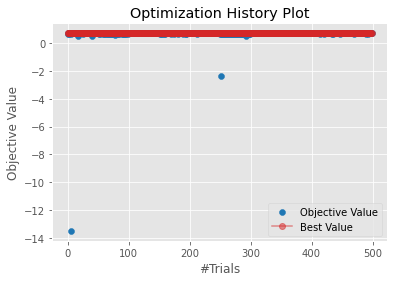

In [99]:
plot_optimization_history(study_xgb);

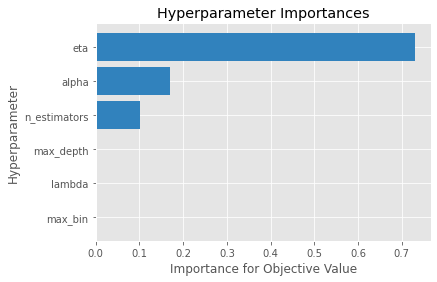

In [100]:
plot_param_importances(study_xgb);

In [101]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.710370,0.042931
1,TP,164.600000,6.203941
2,TN,89.000000,4.396969
3,FP,24.400000,4.005552
4,FN,19.100000,5.506562
5,Accuracy,0.853582,0.023143
6,Precision,0.870995,0.020376
7,Sensitivity,0.896123,0.029191
8,Specificity,0.785090,0.032566
9,F1 score,0.883115,0.019413


In [102]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test['std'] = mat_met_xgb_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.684712,0.733307,0.708160,0.688529,0.708776,0.730538,0.699183,0.691330,0.720596,0.723794,0.708892,0.017721
1,TP,314.000000,332.000000,320.000000,321.000000,326.000000,341.000000,325.000000,316.000000,313.000000,334.000000,324.200000,9.235198
2,TN,184.000000,177.000000,187.000000,180.000000,182.000000,173.000000,176.000000,185.000000,189.000000,171.000000,180.400000,6.040603
3,FP,53.000000,41.000000,50.000000,51.000000,48.000000,49.000000,56.000000,43.000000,55.000000,49.000000,49.500000,4.766783
4,FN,44.000000,45.000000,38.000000,43.000000,39.000000,32.000000,38.000000,51.000000,38.000000,41.000000,40.900000,5.173651
5,Accuracy,0.836975,0.855462,0.852101,0.842017,0.853782,0.863866,0.842017,0.842017,0.843697,0.848739,0.848067,0.008203
6,Precision,0.855586,0.890080,0.864865,0.862903,0.871658,0.874359,0.853018,0.880223,0.850543,0.872063,0.867530,0.012579
7,Sensitivity,0.877095,0.880637,0.893855,0.881868,0.893151,0.914209,0.895317,0.861035,0.891738,0.890667,0.887957,0.013985
8,Specificity,0.776400,0.811900,0.789000,0.779200,0.791300,0.779300,0.758600,0.811400,0.774600,0.777300,0.784900,0.016602
9,F1 score,0.866207,0.885333,0.879121,0.872283,0.882273,0.893840,0.873656,0.870523,0.870654,0.881266,0.877516,0.008387


In [103]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=8,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["rmse"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_xgb_cat = np.where((y_pred_optimized_xgb >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_run0.reset_index(inplace=True, drop=True)
xgb_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_run1.reset_index(inplace=True, drop=True)
xgb_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_run2.reset_index(inplace=True, drop=True)
xgb_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_run3.reset_index(inplace=True, drop=True)
xgb_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
xgb_5preds = pd.concat([chembl_id, xgb_run0, xgb_run1, xgb_run2, xgb_run3, xgb_run4], axis=1)
xgb_5preds = xgb_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds['y_pred_xgb_ave'] = xgb_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds['y_pred_xgb_std'] = xgb_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
xgb_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_xgb0,y_pred_xgb1,y_pred_xgb2,y_pred_xgb3,y_pred_xgb4,y_pred_xgb_ave,y_pred_xgb_std
0,CHEMBL356066,0,8.02,6.989207,7.113615,7.074097,7.089230,7.059748,7.224316,0.357897
1,CHEMBL3652228,1,8.05,8.047163,8.086877,8.001071,8.181213,7.995982,8.060384,0.062249
2,CHEMBL3939518,2,6.87,7.316361,7.274952,7.437621,7.388706,7.586619,7.312377,0.221297
3,CHEMBL4281792,3,7.22,8.302556,7.889215,7.464929,8.024971,7.858667,7.793390,0.356601
4,CHEMBL4070232,4,7.15,6.653418,6.527023,6.503296,6.711822,6.748535,6.715682,0.213816
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL4202521,2966,7.43,6.988164,7.099664,6.795776,6.892704,7.030558,7.039478,0.199906
2967,CHEMBL216641,2967,7.35,7.318423,7.414459,7.453772,7.209116,7.442297,7.364678,0.084651
2968,CHEMBL3693750,2968,7.43,7.539712,7.512382,7.543885,7.694427,7.559728,7.546689,0.078365
2969,CHEMBL152665,2969,5.96,6.506430,6.347733,6.382062,6.371231,6.269535,6.306165,0.169804


In [104]:
mat_met_optimized_xgb.to_csv('mat_met_xgb_opt.csv')
xgb_5preds.to_csv('xgb_5test_CV_result.csv')

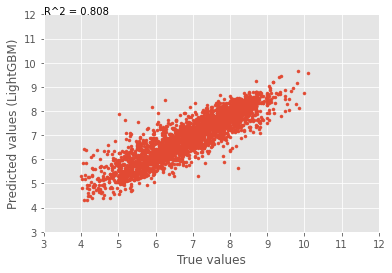

In [105]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'])), (3, 12))
plt.show()

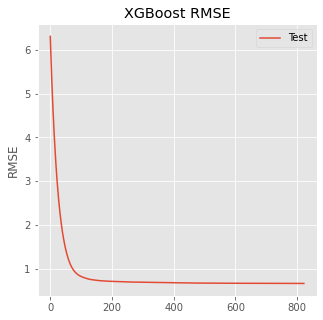

In [106]:
from matplotlib import pyplot
import matplotlib.pyplot as plt  
# retrieve performance metrics
results = optimized_xgb_0.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

 # plot classification error
#fig, ax = pyplot.subplots(figsize=(5,5))
#ax.plot(x_axis, results['validation_0']['error'], label='Train')
#ax.plot(x_axis, results['validation_1']['error'], label='Test')
#ax.legend()
    
#pyplot.ylabel('Classification Error')
#pyplot.title('XGBoost Classification Error')
#pyplot.show()

In [107]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_reg, X, Y, cv=10, scoring="r2", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
print("XGBoost baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

XGBoost baseline model r2_score 0.6689 with a standard deviation of 0.0535
XGBoost optimized model r2_score 0.7125 with a standard deviation of 0.0457


In [108]:
joblib.dump(xgb_reg, "./xgb_reg.joblib")
#joblib.dump(optimized_xgb, "./optimized_xgb.joblib")
joblib.dump(optimizedCV_xgb, "./optimizedCV_xgb.joblib")


['./optimizedCV_xgb.joblib']

## KNeighbors (KNN)

In [109]:
%%time


r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_reg = KNeighborsRegressor()
    
    knn_reg.fit(X_train,y_train)

    y_pred = knn_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.640294     0.021893
1                    TP       164.200000     6.596295
2                    TN        81.700000     4.372896
3                    FP        31.700000     5.292552
4                    FN        19.500000     3.894440
5              Accuracy         0.827670     0.022963
6             Precision         0.838339     0.025792
7           Sensitivity         0.893677     0.022003
8           Specificity         0.721060     0.042036
9              F1 score         0.864913     0.019432
10  F1 score (weighted)         0.825460     0.023476
11     F1 score (macro)         0.813203     0.023870
12    Balanced Accuracy         0.807363     0.024384
13                  MCC         0.630362     0.047065
14                  NPV         0.808180     0.030880
15              ROC_AUC         0.807363     0.024384
CPU times: user 8.39 s, sys: 0 ns, total: 8.39 s
Wall time: 8.39 s


In [110]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=8)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [111]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),      
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=8)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [112]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNregressor")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:54:20,676] A new study created in memory with name: KNNregressor
[I 2023-02-21 04:54:22,015] Trial 0 finished with value: 0.5869906984038908 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 85}. Best is trial 0 with value: 0.5869906984038908.
[I 2023-02-21 04:54:23,351] Trial 1 finished with value: 0.6179908483450154 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 81}. Best is trial 1 with value: 0.6179908483450154.
[I 2023-02-21 04:54:24,890] Trial 2 finished with value: 0.5389824541910032 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 38}. Best is trial 1 with value: 0.6179908483450154.
[I 2023-02-21 04:54:26,734] Trial 3 finished with value: 0.562188045195297 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 31}. Best is trial 1 with value: 0.6179908483450154.
[I 2023-02-21 04:54:28,560]

[I 2023-02-21 04:55:15,755] Trial 35 finished with value: 0.6429317392641223 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 49}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:55:17,115] Trial 36 finished with value: 0.642493805297369 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 74}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:55:18,474] Trial 37 finished with value: 0.6220756319961891 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 67}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:55:20,028] Trial 38 finished with value: 0.6329810473810674 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 41}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:55:21,600] Trial 39 finished with value: 0.6315247593567788 and parameters: {'n_neig

	Number of trials: 50.0
	Best value (r2_score): 0.6446
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 70


In [113]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_knn_0)
# now convert the resuls to binary with cutoff 
y_pred_knn_0_cat = np.where((y_pred_knn_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_knn_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_knn_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_knn_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_knn_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_knn_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_knn_0_cat)
    

mat_met_knn_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    R2    0.615816
1                    TP  320.000000
2                    TN  169.000000
3                    FP   68.000000
4                    FN   38.000000
5              Accuracy    0.821849
6             Precision    0.824742
7           Sensitivity    0.893855
8           Specificity    0.713100
9              F1 score    0.857909
10  F1 score (weighted)    0.819412
11     F1 score (macro)    0.809585
12    Balanced Accuracy    0.803467
13                  MCC    0.623816
14                  NPV    0.816400
15              ROC_AUC    0.803467


In [114]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:55:37,661] Trial 50 finished with value: 0.5759301947256056 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 60}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:55:39,241] Trial 51 finished with value: 0.6237878054026407 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 35}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:55:40,806] Trial 52 finished with value: 0.6209547381491618 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 44}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:55:42,200] Trial 53 finished with value: 0.6215299968009292 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 71}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:55:43,780] Trial 54 finished with value: 0.6237878054026407 and parameters: {'n_ne

[I 2023-02-21 04:56:31,645] Trial 85 finished with value: 0.6175723900457786 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 65}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:56:33,216] Trial 86 finished with value: 0.6209547381491618 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 54}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:56:34,602] Trial 87 finished with value: 0.6127408630798923 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 69}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:56:36,164] Trial 88 finished with value: 0.6241565860418825 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 59}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:56:37,720] Trial 89 finished with value: 0.6237878054026407 and parameters: {'n_nei

	Number of trials: 100.0
	Best value (r2_score): 0.6446
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 70


In [115]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_knn_1)
# now convert the resuls to binary with cutoff 
y_pred_knn_1_cat = np.where((y_pred_knn_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_knn_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_knn_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_knn_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_knn_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_knn_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_knn_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    R2    0.615816    0.672816
1                    TP  320.000000  335.000000
2                    TN  169.000000  170.000000
3                    FP   68.000000   48.000000
4                    FN   38.000000   42.000000
5              Accuracy    0.821849    0.848739
6             Precision    0.824742    0.874674
7           Sensitivity    0.893855    0.888594
8           Specificity    0.713100    0.779800
9              F1 score    0.857909    0.881579
10  F1 score (weighted)    0.819412    0.848281
11     F1 score (macro)    0.809585    0.836138
12    Balanced Accuracy    0.803467    0.834205
13                  MCC    0.623816    0.672473
14                  NPV    0.816400    0.801900
15              ROC_AUC    0.803467    0.834205


In [116]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:56:55,049] Trial 100 finished with value: 0.6101141020133378 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 66}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:56:56,452] Trial 101 finished with value: 0.6371165818503824 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:56:58,071] Trial 102 finished with value: 0.6417335768807011 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 56}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:56:59,464] Trial 103 finished with value: 0.6429123920293375 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 85}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:57:01,092] Trial 104 finished with value: 0.6376222563598113 and parameters: {

[I 2023-02-21 04:57:48,020] Trial 135 finished with value: 0.6305141037356369 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 51}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:57:49,622] Trial 136 finished with value: 0.6376222563598113 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 63}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:57:50,971] Trial 137 finished with value: 0.6371165818503824 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 76}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:57:52,613] Trial 138 finished with value: 0.586907298101206 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 58}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:57:54,198] Trial 139 finished with value: 0.6358301854348055 and parameters: {'

	Number of trials: 150.0
	Best value (r2_score): 0.6446
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 70


In [117]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_knn_2)
# now convert the resuls to binary with cutoff 
y_pred_knn_2_cat = np.where((y_pred_knn_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_knn_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_knn_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_knn_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_knn_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_knn_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_knn_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.615816    0.672816    0.669154
1                    TP  320.000000  335.000000  329.000000
2                    TN  169.000000  170.000000  175.000000
3                    FP   68.000000   48.000000   62.000000
4                    FN   38.000000   42.000000   29.000000
5              Accuracy    0.821849    0.848739    0.847059
6             Precision    0.824742    0.874674    0.841432
7           Sensitivity    0.893855    0.888594    0.918994
8           Specificity    0.713100    0.779800    0.738400
9              F1 score    0.857909    0.881579    0.878505
10  F1 score (weighted)    0.819412    0.848281    0.844706
11     F1 score (macro)    0.809585    0.836138    0.836078
12    Balanced Accuracy    0.803467    0.834205    0.828696
13                  MCC    0.623816    0.672473    0.678010
14                  NPV    0.816400    0.801900    0.857800
15              ROC_AUC    0.803467    0

In [118]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:58:11,792] Trial 150 finished with value: 0.6279865774112976 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 60}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:58:13,443] Trial 151 finished with value: 0.6279865774112976 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 59}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:58:15,041] Trial 152 finished with value: 0.6250579214019312 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 58}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:58:16,665] Trial 153 finished with value: 0.6239541272763166 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 64}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:58:18,277] Trial 154 finished with value: 0.6255758619799033 and parameters: {'

[I 2023-02-21 04:59:03,119] Trial 185 finished with value: 0.6237021990310142 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 85}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:59:04,750] Trial 186 finished with value: 0.6279865774112976 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 66}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:59:06,385] Trial 187 finished with value: 0.6239541272763166 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 56}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:59:08,002] Trial 188 finished with value: 0.6279865774112976 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 53}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:59:09,591] Trial 189 finished with value: 0.6123871960144609 and parameters: {'

	Number of trials: 200.0
	Best value (r2_score): 0.6446
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 70


In [119]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_knn_3)
# now convert the resuls to binary with cutoff 
y_pred_knn_3_cat = np.where((y_pred_knn_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_knn_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_knn_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_knn_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_knn_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_knn_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_knn_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.615816    0.672816    0.669154    0.659064
1                    TP  320.000000  335.000000  329.000000  328.000000
2                    TN  169.000000  170.000000  175.000000  175.000000
3                    FP   68.000000   48.000000   62.000000   56.000000
4                    FN   38.000000   42.000000   29.000000   36.000000
5              Accuracy    0.821849    0.848739    0.847059    0.845378
6             Precision    0.824742    0.874674    0.841432    0.854167
7           Sensitivity    0.893855    0.888594    0.918994    0.901099
8           Specificity    0.713100    0.779800    0.738400    0.757600
9              F1 score    0.857909    0.881579    0.878505    0.877005
10  F1 score (weighted)    0.819412    0.848281    0.844706    0.843947
11     F1 score (macro)    0.809585    0.836138    0.836078    0.834430
12    Balanced Accuracy    0.803467    0.834205    0.828696    0

In [120]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 04:59:26,213] Trial 200 finished with value: 0.6322254279477072 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 58}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:59:27,570] Trial 201 finished with value: 0.6330424831675278 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 90}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:59:28,925] Trial 202 finished with value: 0.6330424831675278 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 81}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:59:30,587] Trial 203 finished with value: 0.6322254279477072 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 55}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 04:59:32,193] Trial 204 finished with value: 0.6336596789331118 and parameters: {'

[I 2023-02-21 05:00:19,054] Trial 235 finished with value: 0.6322254279477072 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 54}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:00:20,697] Trial 236 finished with value: 0.6336596789331118 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 53}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:00:22,090] Trial 237 finished with value: 0.6346302242828952 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 84}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:00:23,463] Trial 238 finished with value: 0.6330424831675278 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 88}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:00:25,066] Trial 239 finished with value: 0.625530691910748 and parameters: {'n

	Number of trials: 250.0
	Best value (r2_score): 0.6446
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 70


In [121]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_knn_4)
# now convert the resuls to binary with cutoff 
y_pred_knn_4_cat = np.where((y_pred_knn_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_knn_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_knn_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_knn_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_knn_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_knn_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_knn_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.615816    0.672816    0.669154    0.659064   
1                    TP  320.000000  335.000000  329.000000  328.000000   
2                    TN  169.000000  170.000000  175.000000  175.000000   
3                    FP   68.000000   48.000000   62.000000   56.000000   
4                    FN   38.000000   42.000000   29.000000   36.000000   
5              Accuracy    0.821849    0.848739    0.847059    0.845378   
6             Precision    0.824742    0.874674    0.841432    0.854167   
7           Sensitivity    0.893855    0.888594    0.918994    0.901099   
8           Specificity    0.713100    0.779800    0.738400    0.757600   
9              F1 score    0.857909    0.881579    0.878505    0.877005   
10  F1 score (weighted)    0.819412    0.848281    0.844706    0.843947   
11     F1 score (macro)    0.809585    0.836138    0.836078    0.834430   
12    Balanced Accuracy  

In [122]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 05:00:43,198] Trial 250 finished with value: 0.6167672984103204 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 60}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:00:44,778] Trial 251 finished with value: 0.6164411932380309 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 57}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:00:46,159] Trial 252 finished with value: 0.6184994673635387 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 72}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:00:47,516] Trial 253 finished with value: 0.6174163479752133 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 68}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:00:49,144] Trial 254 finished with value: 0.6149674106919938 and parameters: {'

[I 2023-02-21 05:01:36,701] Trial 285 finished with value: 0.6164411932380309 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 47}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:01:38,315] Trial 286 finished with value: 0.6149674106919938 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 55}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:01:39,675] Trial 287 finished with value: 0.6096995196639606 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 71}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:01:41,273] Trial 288 finished with value: 0.6164411932380309 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 54}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:01:42,644] Trial 289 finished with value: 0.6174163479752133 and parameters: {'

	Number of trials: 300.0
	Best value (r2_score): 0.6446
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 70


In [123]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_knn_5)
# now convert the resuls to binary with cutoff 
y_pred_knn_5_cat = np.where((y_pred_knn_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_knn_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_knn_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_knn_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_knn_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_knn_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_knn_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.615816    0.672816    0.669154    0.659064   
1                    TP  320.000000  335.000000  329.000000  328.000000   
2                    TN  169.000000  170.000000  175.000000  175.000000   
3                    FP   68.000000   48.000000   62.000000   56.000000   
4                    FN   38.000000   42.000000   29.000000   36.000000   
5              Accuracy    0.821849    0.848739    0.847059    0.845378   
6             Precision    0.824742    0.874674    0.841432    0.854167   
7           Sensitivity    0.893855    0.888594    0.918994    0.901099   
8           Specificity    0.713100    0.779800    0.738400    0.757600   
9              F1 score    0.857909    0.881579    0.878505    0.877005   
10  F1 score (weighted)    0.819412    0.848281    0.844706    0.843947   
11     F1 score (macro)    0.809585    0.836138    0.836078    0.834430   
12    Balanced Accuracy  

In [124]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 05:01:59,105] Trial 300 finished with value: 0.6099400473007227 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 57}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:02:00,708] Trial 301 finished with value: 0.638408971741637 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 59}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:02:02,363] Trial 302 finished with value: 0.638408971741637 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 62}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:02:03,989] Trial 303 finished with value: 0.6362385289477439 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 45}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:02:05,376] Trial 304 finished with value: 0.6331729157671993 and parameters: {'n

[I 2023-02-21 05:02:52,325] Trial 335 finished with value: 0.577847566322659 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 71}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:02:53,682] Trial 336 finished with value: 0.6386458005664057 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 94}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:02:55,283] Trial 337 finished with value: 0.638408971741637 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 57}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:02:56,920] Trial 338 finished with value: 0.6362385289477439 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 46}. Best is trial 16 with value: 0.6446132537477182.
[I 2023-02-21 05:02:58,276] Trial 339 finished with value: 0.6386458005664057 and parameters: {'n

	Number of trials: 350.0
	Best value (r2_score): 0.6446
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 70


In [125]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_knn_6)
# now convert the resuls to binary with cutoff 
y_pred_knn_6_cat = np.where((y_pred_knn_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_knn_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_knn_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_knn_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_knn_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_knn_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_knn_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.615816    0.672816    0.669154    0.659064   
1                    TP  320.000000  335.000000  329.000000  328.000000   
2                    TN  169.000000  170.000000  175.000000  175.000000   
3                    FP   68.000000   48.000000   62.000000   56.000000   
4                    FN   38.000000   42.000000   29.000000   36.000000   
5              Accuracy    0.821849    0.848739    0.847059    0.845378   
6             Precision    0.824742    0.874674    0.841432    0.854167   
7           Sensitivity    0.893855    0.888594    0.918994    0.901099   
8           Specificity    0.713100    0.779800    0.738400    0.757600   
9              F1 score    0.857909    0.881579    0.878505    0.877005   
10  F1 score (weighted)    0.819412    0.848281    0.844706    0.843947   
11     F1 score (macro)    0.809585    0.836138    0.836078    0.834430   
12    Balanced Accuracy  

In [126]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 05:03:15,135] Trial 350 finished with value: 0.6464883939383655 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 55}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:03:16,783] Trial 351 finished with value: 0.6452520782344424 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 54}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:03:18,419] Trial 352 finished with value: 0.6400041966081982 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 52}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:03:20,067] Trial 353 finished with value: 0.609660380468139 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 54}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:03:21,649] Trial 354 finished with value: 0.6452520782344424 and parameters: 

[I 2023-02-21 05:04:11,987] Trial 385 finished with value: 0.6426590402814019 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 52}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:04:13,606] Trial 386 finished with value: 0.6452520782344424 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 50}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:04:15,201] Trial 387 finished with value: 0.6452520782344424 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 50}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:04:16,821] Trial 388 finished with value: 0.6426590402814019 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 50}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:04:18,443] Trial 389 finished with value: 0.6452520782344424 and parameters

	Number of trials: 400.0
	Best value (r2_score): 0.6465
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 55


In [127]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_knn_7)
# now convert the resuls to binary with cutoff 
y_pred_knn_7_cat = np.where((y_pred_knn_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_knn_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_knn_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_knn_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_knn_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_knn_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_knn_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.615816    0.672816    0.669154    0.659064   
1                    TP  320.000000  335.000000  329.000000  328.000000   
2                    TN  169.000000  170.000000  175.000000  175.000000   
3                    FP   68.000000   48.000000   62.000000   56.000000   
4                    FN   38.000000   42.000000   29.000000   36.000000   
5              Accuracy    0.821849    0.848739    0.847059    0.845378   
6             Precision    0.824742    0.874674    0.841432    0.854167   
7           Sensitivity    0.893855    0.888594    0.918994    0.901099   
8           Specificity    0.713100    0.779800    0.738400    0.757600   
9              F1 score    0.857909    0.881579    0.878505    0.877005   
10  F1 score (weighted)    0.819412    0.848281    0.844706    0.843947   
11     F1 score (macro)    0.809585    0.836138    0.836078    0.834430   
12    Balanced Accuracy  

In [128]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 05:04:36,654] Trial 400 finished with value: 0.6255374012580631 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 51}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:04:38,237] Trial 401 finished with value: 0.6255374012580631 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 51}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:04:39,822] Trial 402 finished with value: 0.6294742684570054 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 52}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:04:41,445] Trial 403 finished with value: 0.6255374012580631 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 49}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:04:43,076] Trial 404 finished with value: 0.6294742684570054 and parameters

[I 2023-02-21 05:05:33,259] Trial 435 finished with value: 0.6255374012580631 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 49}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:05:34,914] Trial 436 finished with value: 0.6294742684570054 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 53}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:05:36,514] Trial 437 finished with value: 0.6255374012580631 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 50}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:05:38,129] Trial 438 finished with value: 0.6161348445259944 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 52}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:05:39,718] Trial 439 finished with value: 0.6066630624453085 and parameters

	Number of trials: 450.0
	Best value (r2_score): 0.6465
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 55


In [129]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_knn_8)
# now convert the resuls to binary with cutoff 
y_pred_knn_8_cat = np.where((y_pred_knn_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_knn_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_knn_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_knn_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_knn_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_knn_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_knn_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.615816    0.672816    0.669154    0.659064   
1                    TP  320.000000  335.000000  329.000000  328.000000   
2                    TN  169.000000  170.000000  175.000000  175.000000   
3                    FP   68.000000   48.000000   62.000000   56.000000   
4                    FN   38.000000   42.000000   29.000000   36.000000   
5              Accuracy    0.821849    0.848739    0.847059    0.845378   
6             Precision    0.824742    0.874674    0.841432    0.854167   
7           Sensitivity    0.893855    0.888594    0.918994    0.901099   
8           Specificity    0.713100    0.779800    0.738400    0.757600   
9              F1 score    0.857909    0.881579    0.878505    0.877005   
10  F1 score (weighted)    0.819412    0.848281    0.844706    0.843947   
11     F1 score (macro)    0.809585    0.836138    0.836078    0.834430   
12    Balanced Accuracy  

In [130]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 05:05:58,094] Trial 450 finished with value: 0.6344341698965692 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 57}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:05:59,730] Trial 451 finished with value: 0.6316233645458864 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 53}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:06:01,371] Trial 452 finished with value: 0.6238047233556737 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 52}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:06:03,042] Trial 453 finished with value: 0.6316233645458864 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 56}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:06:04,660] Trial 454 finished with value: 0.6344341698965692 and parameters:

[I 2023-02-21 05:06:54,616] Trial 485 finished with value: 0.6316233645458864 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 48}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:06:56,231] Trial 486 finished with value: 0.6344341698965692 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 52}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:06:57,851] Trial 487 finished with value: 0.6251784069562346 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 51}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:06:59,467] Trial 488 finished with value: 0.6308260264487194 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 50}. Best is trial 350 with value: 0.6464883939383655.
[I 2023-02-21 05:07:01,135] Trial 489 finished with value: 0.6238047233556737 and parameters

	Number of trials: 500.0
	Best value (r2_score): 0.6465
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 55


In [131]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_knn_9)
# now convert the resuls to binary with cutoff 
y_pred_knn_9_cat = np.where((y_pred_knn_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_knn_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_knn_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_knn_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_knn_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_knn_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_knn_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.615816    0.672816    0.669154    0.659064   
1                    TP  320.000000  335.000000  329.000000  328.000000   
2                    TN  169.000000  170.000000  175.000000  175.000000   
3                    FP   68.000000   48.000000   62.000000   56.000000   
4                    FN   38.000000   42.000000   29.000000   36.000000   
5              Accuracy    0.821849    0.848739    0.847059    0.845378   
6             Precision    0.824742    0.874674    0.841432    0.854167   
7           Sensitivity    0.893855    0.888594    0.918994    0.901099   
8           Specificity    0.713100    0.779800    0.738400    0.757600   
9              F1 score    0.857909    0.881579    0.878505    0.877005   
10  F1 score (weighted)    0.819412    0.848281    0.844706    0.843947   
11     F1 score (macro)    0.809585    0.836138    0.836078    0.834430   
12    Balanced Accuracy  

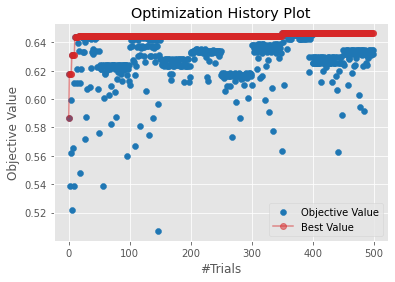

In [132]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

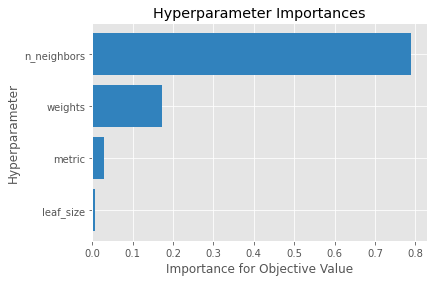

In [133]:

plot_param_importances(study_knn);

In [134]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.655326,0.026284
1,TP,166.200000,6.696599
2,TN,82.800000,3.765339
3,FP,30.600000,5.660781
4,FN,17.500000,4.648775
5,Accuracy,0.838098,0.025392
6,Precision,0.844672,0.027525
7,Sensitivity,0.904638,0.025431
8,Specificity,0.731080,0.042736
9,F1 score,0.873356,0.021205


In [135]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test['std'] = mat_met_knn_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.615816,0.672816,0.669154,0.659064,0.689168,0.651150,0.650946,0.623832,0.648132,0.665763,0.654584,0.022113
1,TP,320.000000,335.000000,329.000000,328.000000,334.000000,342.000000,329.000000,324.000000,322.000000,344.000000,330.700000,8.042250
2,TN,169.000000,170.000000,175.000000,175.000000,178.000000,170.000000,159.000000,171.000000,175.000000,167.000000,170.900000,5.404730
3,FP,68.000000,48.000000,62.000000,56.000000,52.000000,52.000000,73.000000,57.000000,69.000000,53.000000,59.000000,8.524475
4,FN,38.000000,42.000000,29.000000,36.000000,31.000000,31.000000,34.000000,43.000000,29.000000,31.000000,34.400000,5.168279
5,Accuracy,0.821849,0.848739,0.847059,0.845378,0.860504,0.860504,0.820168,0.831933,0.835294,0.858824,0.843025,0.015161
6,Precision,0.824742,0.874674,0.841432,0.854167,0.865285,0.868020,0.818408,0.850394,0.823529,0.866499,0.848715,0.020684
7,Sensitivity,0.893855,0.888594,0.918994,0.901099,0.915068,0.916890,0.906336,0.882834,0.917379,0.917333,0.905838,0.013493
8,Specificity,0.713100,0.779800,0.738400,0.757600,0.773900,0.765800,0.685300,0.750000,0.717200,0.759100,0.744020,0.030276
9,F1 score,0.857909,0.881579,0.878505,0.877005,0.889481,0.891786,0.860131,0.866310,0.867925,0.891192,0.876182,0.012640


In [136]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=8,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_run0.sort_values(by='y_test_idx0', inplace=True)
knn_run0.reset_index(inplace=True, drop=True)
knn_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_run1.sort_values(by='y_test_idx1', inplace=True)
knn_run1.reset_index(inplace=True, drop=True)
knn_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_run2.sort_values(by='y_test_idx2', inplace=True)
knn_run2.reset_index(inplace=True, drop=True)
knn_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_run3.sort_values(by='y_test_idx3', inplace=True)
knn_run3.reset_index(inplace=True, drop=True)
knn_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_run4.sort_values(by='y_test_idx4', inplace=True)
knn_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
knn_5preds = pd.concat([chembl_id, knn_run0, knn_run1, knn_run2, knn_run3, knn_run4], axis=1)
knn_5preds = knn_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds['y_pred_knn_ave'] = knn_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds['y_pred_knn_std'] = knn_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,CHEMBL356066,0,8.02,7.101069,7.101069,7.034960,7.101069,7.101069,7.243206,0.348231
1,CHEMBL3652228,1,8.05,8.106915,8.021567,8.021567,8.021567,8.021567,8.040530,0.031451
2,CHEMBL3939518,2,6.87,7.574042,7.583610,7.574042,7.606467,7.655317,7.477246,0.273010
3,CHEMBL4281792,3,7.22,8.235000,7.850000,7.405000,7.910000,7.850000,7.745000,0.336799
4,CHEMBL4070232,4,7.15,7.119514,6.928830,6.928830,6.928830,7.119514,7.029253,0.100936
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL4202521,2966,7.43,6.978539,7.030952,7.030952,7.030952,6.916975,7.069728,0.166311
2967,CHEMBL216641,2967,7.35,6.920277,7.263123,7.313291,7.263123,7.261517,7.228555,0.141681
2968,CHEMBL3693750,2968,7.43,7.515533,7.537293,7.515533,7.515533,7.515533,7.504904,0.034428
2969,CHEMBL152665,2969,5.96,6.695202,6.388462,6.695202,6.218352,6.218352,6.362595,0.266339


In [137]:
mat_met_optimized_knn.to_csv('mat_met_knn_opt.csv')
knn_5preds.to_csv('knn_5test_CV_result.csv')

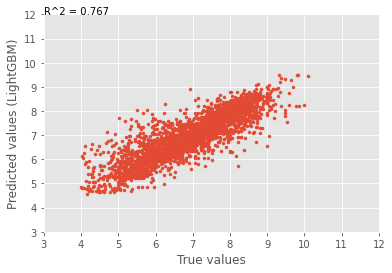

In [138]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'])), (3, 12))
plt.show()

In [139]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_reg, X, Y, cv=10, scoring="r2")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="r2")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="r2")
print("KNN baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model r2_score 0.6403 with a standard deviation of 0.0611
KNN optimized model r2_score 0.6490 with a standard deviation of 0.0590


In [140]:
joblib.dump(knn_reg, "./knn_reg.joblib")
#joblib.dump(optimized_knn, "./optimized_knn.joblib")
joblib.dump(optimizedCV_knn, "./optimizedCV_knn.joblib")
#loaded_rf = joblib.load("./optimized_rf.joblib")

['./optimizedCV_knn.joblib']

## Support Vector 

In [141]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_reg = SVR()
    
    svm_reg.fit(X_train, y_train, )

    y_pred = svm_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.693773     0.031180
1                    TP       165.600000     6.484169
2                    TN        86.500000     3.979112
3                    FP        26.900000     3.212822
4                    FN        18.100000     5.506562
5              Accuracy         0.848533     0.021134
6             Precision         0.860236     0.016142
7           Sensitivity         0.901523     0.029400
8           Specificity         0.762940     0.025166
9              F1 score         0.880166     0.018100
10  F1 score (weighted)         0.847270     0.020787
11     F1 score (macro)         0.836962     0.021617
12    Balanced Accuracy         0.832225     0.019649
13                  MCC         0.676463     0.043865
14                  NPV         0.828560     0.043732
15              ROC_AUC         0.832225     0.019649
CPU times: user 45.1 s, sys: 28 ms, total: 45.1 s
Wall time: 45.1 s


In [142]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)


In [143]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [144]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_regressor_CV")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 05:08:32,040] A new study created in memory with name: SVM_regressor_CV
[I 2023-02-21 05:09:03,450] Trial 0 finished with value: 0.5807661476054035 and parameters: {'C': 64.0, 'gamma': 0.00048828125}. Best is trial 0 with value: 0.5807661476054035.
[I 2023-02-21 05:09:32,600] Trial 1 finished with value: 0.6894911052797668 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 1 with value: 0.6894911052797668.
[I 2023-02-21 05:10:05,918] Trial 2 finished with value: 0.03116819693838043 and parameters: {'C': 64.0, 'gamma': 8.0}. Best is trial 1 with value: 0.6894911052797668.
[I 2023-02-21 05:10:37,764] Trial 3 finished with value: 0.11166867297717506 and parameters: {'C': 0.015625, 'gamma': 0.00390625}. Best is trial 1 with value: 0.6894911052797668.
[I 2023-02-21 05:11:08,284] Trial 4 finished with value: 0.4137022257645936 and parameters: {'C': 0.125, 'gamma': 0.00390625}. Best is trial 1 with value: 0.6894911052797668.
[I 2023-02-21 05:11:40,261] Trial 5 finishe

[I 2023-02-21 05:31:15,184] Trial 44 finished with value: 0.03171459027439307 and parameters: {'C': 128.0, 'gamma': 4.0}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:31:46,937] Trial 45 finished with value: 0.036642965510159706 and parameters: {'C': 0.125, 'gamma': 0.0001220703125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:32:18,705] Trial 46 finished with value: 0.0036626968403053683 and parameters: {'C': 0.0625, 'gamma': 0.25}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:32:50,547] Trial 47 finished with value: 0.06015778026535853 and parameters: {'C': 8.0, 'gamma': 0.5}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:33:19,453] Trial 48 finished with value: 0.6500631629553911 and parameters: {'C': 1.0, 'gamma': 0.0078125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:33:49,167] Trial 49 finished with value: 0.4967354435300601 and parameters: {'C': 0.25, 'gamma': 0.00390625}. 

	Number of trials: 50.0
	Best value (r2_score): 0.6936
	Best params:
		C: 8.0
		gamma: 0.015625


In [145]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_svm_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_0_cat = np.where((y_pred_svm_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_svm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_svm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_svm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_svm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_svm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_svm_0_cat)
    

mat_met_svm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    R2    0.673671
1                    TP  320.000000
2                    TN  176.000000
3                    FP   61.000000
4                    FN   38.000000
5              Accuracy    0.833613
6             Precision    0.839895
7           Sensitivity    0.893855
8           Specificity    0.742600
9              F1 score    0.866035
10  F1 score (weighted)    0.831960
11     F1 score (macro)    0.823261
12    Balanced Accuracy    0.818235
13                  MCC    0.649269
14                  NPV    0.822400
15              ROC_AUC    0.818235


In [146]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 05:34:22,969] Trial 50 finished with value: 0.5015301241588085 and parameters: {'C': 4.0, 'gamma': 0.000244140625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:34:51,940] Trial 51 finished with value: 0.684073524243196 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:35:20,903] Trial 52 finished with value: 0.684073524243196 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:35:51,213] Trial 53 finished with value: 0.4323829398258754 and parameters: {'C': 8.0, 'gamma': 6.103515625e-05}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:36:22,581] Trial 54 finished with value: 0.16039123129487876 and parameters: {'C': 0.015625, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:36:51,546] Trial 55 finished with value: 0.684073524243196 and parameters: {'C': 8.0, 'gamma': 0.0156

[I 2023-02-21 05:56:25,128] Trial 94 finished with value: 0.6806834220852537 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:56:55,471] Trial 95 finished with value: 0.3845748131853229 and parameters: {'C': 0.0625, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:57:25,077] Trial 96 finished with value: 0.5877648804521207 and parameters: {'C': 8.0, 'gamma': 0.00048828125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:57:53,879] Trial 97 finished with value: 0.6656288473767327 and parameters: {'C': 1.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:58:25,479] Trial 98 finished with value: 0.26889387164466 and parameters: {'C': 8.0, 'gamma': 0.125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 05:58:56,478] Trial 99 finished with value: 0.26832587079636583 and parameters: {'C': 0.03125, 'gamma': 0.015625}. B

	Number of trials: 100.0
	Best value (r2_score): 0.6936
	Best params:
		C: 8.0
		gamma: 0.015625


In [147]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_svm_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_1_cat = np.where((y_pred_svm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_svm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_svm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_svm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_svm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_svm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_svm_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    R2    0.673671    0.721557
1                    TP  320.000000  341.000000
2                    TN  176.000000  168.000000
3                    FP   61.000000   50.000000
4                    FN   38.000000   36.000000
5              Accuracy    0.833613    0.855462
6             Precision    0.839895    0.872123
7           Sensitivity    0.893855    0.904509
8           Specificity    0.742600    0.770600
9              F1 score    0.866035    0.888021
10  F1 score (weighted)    0.831960    0.854382
11     F1 score (macro)    0.823261    0.842115
12    Balanced Accuracy    0.818235    0.837576
13                  MCC    0.649269    0.685325
14                  NPV    0.822400    0.823500
15              ROC_AUC    0.818235    0.837576


In [148]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 05:59:33,519] Trial 100 finished with value: 0.01911329847014146 and parameters: {'C': 32.0, 'gamma': 8.0}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:00:02,491] Trial 101 finished with value: 0.6822693744521852 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:00:31,977] Trial 102 finished with value: 0.5655297146073297 and parameters: {'C': 0.25, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:01:00,952] Trial 103 finished with value: 0.6822693744521852 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:01:30,827] Trial 104 finished with value: 0.5553091855722927 and parameters: {'C': 8.0, 'gamma': 0.0625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:01:59,631] Trial 105 finished with value: 0.6922791334295182 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is

[I 2023-02-21 06:21:12,351] Trial 144 finished with value: 0.6922791334295182 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:21:44,021] Trial 145 finished with value: 0.007720535589385047 and parameters: {'C': 0.03125, 'gamma': 0.125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:22:16,733] Trial 146 finished with value: 0.01911321783473118 and parameters: {'C': 8.0, 'gamma': 8.0}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:22:45,424] Trial 147 finished with value: 0.6681547457498589 and parameters: {'C': 1.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:23:13,903] Trial 148 finished with value: 0.6880611334672301 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:23:43,852] Trial 149 finished with value: 0.36165633756459814 and parameters: {'C': 0.25, 'gamma': 0.0625}. Best i

	Number of trials: 150.0
	Best value (r2_score): 0.6936
	Best params:
		C: 8.0
		gamma: 0.015625


In [149]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_svm_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_2_cat = np.where((y_pred_svm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_svm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_svm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_svm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_svm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_svm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_svm_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.673671    0.721557    0.722501
1                    TP  320.000000  341.000000  328.000000
2                    TN  176.000000  168.000000  191.000000
3                    FP   61.000000   50.000000   46.000000
4                    FN   38.000000   36.000000   30.000000
5              Accuracy    0.833613    0.855462    0.872269
6             Precision    0.839895    0.872123    0.877005
7           Sensitivity    0.893855    0.904509    0.916201
8           Specificity    0.742600    0.770600    0.805900
9              F1 score    0.866035    0.888021    0.896175
10  F1 score (weighted)    0.831960    0.854382    0.871434
11     F1 score (macro)    0.823261    0.842115    0.865118
12    Balanced Accuracy    0.818235    0.837576    0.861054
13                  MCC    0.649269    0.685325    0.731621
14                  NPV    0.822400    0.823500    0.864300
15              ROC_AUC    0.818235    0

In [150]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 06:24:15,593] Trial 150 finished with value: 0.6837849755322805 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:24:43,434] Trial 151 finished with value: 0.6837849755322805 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:25:11,266] Trial 152 finished with value: 0.6837849755322805 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:25:39,099] Trial 153 finished with value: 0.6837849755322805 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:26:06,932] Trial 154 finished with value: 0.6837849755322805 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:26:35,154] Trial 155 finished with value: 0.6674287255669755 and parameters: {'C': 8.0, 'gamma': 0.0078125}. Best

[I 2023-02-21 06:45:18,418] Trial 194 finished with value: 0.0013767323257105613 and parameters: {'C': 0.25, 'gamma': 8.0}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:45:46,244] Trial 195 finished with value: 0.6837849755322805 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:46:15,019] Trial 196 finished with value: 0.5844603624854804 and parameters: {'C': 8.0, 'gamma': 0.00048828125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:46:42,853] Trial 197 finished with value: 0.6837849755322805 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:47:10,822] Trial 198 finished with value: 0.6778224583598063 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:47:39,818] Trial 199 finished with value: 0.5478621898102264 and parameters: {'C': 4.0, 'gamma': 0.0625}. Bes

	Number of trials: 200.0
	Best value (r2_score): 0.6936
	Best params:
		C: 8.0
		gamma: 0.015625


In [151]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_svm_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_3_cat = np.where((y_pred_svm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_svm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_svm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_svm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_svm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_svm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_svm_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.673671    0.721557    0.722501    0.705563
1                    TP  320.000000  341.000000  328.000000  327.000000
2                    TN  176.000000  168.000000  191.000000  182.000000
3                    FP   61.000000   50.000000   46.000000   49.000000
4                    FN   38.000000   36.000000   30.000000   37.000000
5              Accuracy    0.833613    0.855462    0.872269    0.855462
6             Precision    0.839895    0.872123    0.877005    0.869681
7           Sensitivity    0.893855    0.904509    0.916201    0.898352
8           Specificity    0.742600    0.770600    0.805900    0.787900
9              F1 score    0.866035    0.888021    0.896175    0.883784
10  F1 score (weighted)    0.831960    0.854382    0.871434    0.854707
11     F1 score (macro)    0.823261    0.842115    0.865118    0.846336
12    Balanced Accuracy    0.818235    0.837576    0.861054    0

In [152]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 06:48:11,646] Trial 200 finished with value: 0.6847505472753335 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:48:42,239] Trial 201 finished with value: 0.2855049984430771 and parameters: {'C': 4.0, 'gamma': 0.125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:49:10,328] Trial 202 finished with value: 0.6858118314811711 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:49:38,420] Trial 203 finished with value: 0.6858118314811711 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:50:06,511] Trial 204 finished with value: 0.6858118314811711 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 06:50:34,593] Trial 205 finished with value: 0.6838080142139599 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is 

[I 2023-02-21 07:09:18,326] Trial 244 finished with value: 0.6838080142139599 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:09:46,418] Trial 245 finished with value: 0.6858118314811711 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:10:15,028] Trial 246 finished with value: 0.5689108683898148 and parameters: {'C': 0.25, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:10:43,033] Trial 247 finished with value: 0.6727188228430229 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:11:11,842] Trial 248 finished with value: 0.5793622791368476 and parameters: {'C': 8.0, 'gamma': 0.00048828125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:11:39,933] Trial 249 finished with value: 0.6858118314811711 and parameters: {'C': 4.0, 'gamma': 0.015625}. 

	Number of trials: 250.0
	Best value (r2_score): 0.6936
	Best params:
		C: 8.0
		gamma: 0.015625


In [153]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_svm_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_4_cat = np.where((y_pred_svm_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_svm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_svm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_svm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_svm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_svm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_svm_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.673671    0.721557    0.722501    0.705563   
1                    TP  320.000000  341.000000  328.000000  327.000000   
2                    TN  176.000000  168.000000  191.000000  182.000000   
3                    FP   61.000000   50.000000   46.000000   49.000000   
4                    FN   38.000000   36.000000   30.000000   37.000000   
5              Accuracy    0.833613    0.855462    0.872269    0.855462   
6             Precision    0.839895    0.872123    0.877005    0.869681   
7           Sensitivity    0.893855    0.904509    0.916201    0.898352   
8           Specificity    0.742600    0.770600    0.805900    0.787900   
9              F1 score    0.866035    0.888021    0.896175    0.883784   
10  F1 score (weighted)    0.831960    0.854382    0.871434    0.854707   
11     F1 score (macro)    0.823261    0.842115    0.865118    0.846336   
12    Balanced Accuracy  

In [154]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 07:12:12,009] Trial 250 finished with value: 0.6771381472708761 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:12:40,261] Trial 251 finished with value: 0.6750612859736858 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:13:08,430] Trial 252 finished with value: 0.6771381472708761 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:13:39,514] Trial 253 finished with value: 0.2709446352542908 and parameters: {'C': 2.0, 'gamma': 0.125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:14:10,157] Trial 254 finished with value: 0.16315629629956135 and parameters: {'C': 0.015625, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:14:39,113] Trial 255 finished with value: 0.5447900759910524 and parameters: {'C': 4.0, 'gamma': 0.0625}. Best

[I 2023-02-21 07:33:37,860] Trial 294 finished with value: 0.008330012280800447 and parameters: {'C': 2.0, 'gamma': 8.0}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:34:06,778] Trial 295 finished with value: 0.5863154003897897 and parameters: {'C': 16.0, 'gamma': 0.00048828125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:34:37,408] Trial 296 finished with value: 0.2722770977264709 and parameters: {'C': 4.0, 'gamma': 0.125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:35:05,659] Trial 297 finished with value: 0.6750612859736858 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:35:33,819] Trial 298 finished with value: 0.6771381472708761 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:36:04,655] Trial 299 finished with value: 0.03116073567564952 and parameters: {'C': 0.015625, 'gamma': 0.0625}. B

	Number of trials: 300.0
	Best value (r2_score): 0.6936
	Best params:
		C: 8.0
		gamma: 0.015625


In [155]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_svm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_5_cat = np.where((y_pred_svm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_svm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_svm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_svm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_svm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_svm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_svm_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.673671    0.721557    0.722501    0.705563   
1                    TP  320.000000  341.000000  328.000000  327.000000   
2                    TN  176.000000  168.000000  191.000000  182.000000   
3                    FP   61.000000   50.000000   46.000000   49.000000   
4                    FN   38.000000   36.000000   30.000000   37.000000   
5              Accuracy    0.833613    0.855462    0.872269    0.855462   
6             Precision    0.839895    0.872123    0.877005    0.869681   
7           Sensitivity    0.893855    0.904509    0.916201    0.898352   
8           Specificity    0.742600    0.770600    0.805900    0.787900   
9              F1 score    0.866035    0.888021    0.896175    0.883784   
10  F1 score (weighted)    0.831960    0.854382    0.871434    0.854707   
11     F1 score (macro)    0.823261    0.842115    0.865118    0.846336   
12    Balanced Accuracy  

In [156]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 07:36:36,657] Trial 300 finished with value: 0.693142561254053 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:37:04,763] Trial 301 finished with value: 0.6900144967469092 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:37:32,807] Trial 302 finished with value: 0.693142561254053 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:38:00,871] Trial 303 finished with value: 0.693142561254053 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:38:28,964] Trial 304 finished with value: 0.693142561254053 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:38:57,010] Trial 305 finished with value: 0.693142561254053 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is tr

[I 2023-02-21 07:57:58,767] Trial 344 finished with value: 0.693142561254053 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:58:27,516] Trial 345 finished with value: 0.693142561254053 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:58:56,254] Trial 346 finished with value: 0.693142561254053 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:59:27,590] Trial 347 finished with value: 0.27097423627476475 and parameters: {'C': 8.0, 'gamma': 0.125}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 07:59:56,329] Trial 348 finished with value: 0.693142561254053 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 08:00:25,217] Trial 349 finished with value: 0.6859912850022686 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is tr

	Number of trials: 350.0
	Best value (r2_score): 0.6936
	Best params:
		C: 8.0
		gamma: 0.015625


In [157]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_svm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_6_cat = np.where((y_pred_svm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_svm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_svm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_svm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_svm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_svm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_svm_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.673671    0.721557    0.722501    0.705563   
1                    TP  320.000000  341.000000  328.000000  327.000000   
2                    TN  176.000000  168.000000  191.000000  182.000000   
3                    FP   61.000000   50.000000   46.000000   49.000000   
4                    FN   38.000000   36.000000   30.000000   37.000000   
5              Accuracy    0.833613    0.855462    0.872269    0.855462   
6             Precision    0.839895    0.872123    0.877005    0.869681   
7           Sensitivity    0.893855    0.904509    0.916201    0.898352   
8           Specificity    0.742600    0.770600    0.805900    0.787900   
9              F1 score    0.866035    0.888021    0.896175    0.883784   
10  F1 score (weighted)    0.831960    0.854382    0.871434    0.854707   
11     F1 score (macro)    0.823261    0.842115    0.865118    0.846336   
12    Balanced Accuracy  

In [158]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 08:01:02,143] Trial 350 finished with value: 0.02373579483380388 and parameters: {'C': 4.0, 'gamma': 8.0}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 08:01:31,548] Trial 351 finished with value: 0.5668142829212602 and parameters: {'C': 8.0, 'gamma': 0.0625}. Best is trial 31 with value: 0.6936052872848771.
[I 2023-02-21 08:01:59,827] Trial 352 finished with value: 0.6989360807510077 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:02:28,253] Trial 353 finished with value: 0.6432445932749933 and parameters: {'C': 0.5, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:02:56,495] Trial 354 finished with value: 0.6841380760038571 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:03:24,667] Trial 355 finished with value: 0.6989360807510077 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is

[I 2023-02-21 08:22:01,450] Trial 394 finished with value: 0.6954236535729417 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:22:29,342] Trial 395 finished with value: 0.6954236535729417 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:22:57,281] Trial 396 finished with value: 0.6954236535729417 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:23:25,187] Trial 397 finished with value: 0.6954236535729417 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:23:53,832] Trial 398 finished with value: 0.6016674377326232 and parameters: {'C': 8.0, 'gamma': 0.00048828125}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:24:21,720] Trial 399 finished with value: 0.6954236535729417 and parameters: {'C': 8.0, 'gamma': 0.0156

	Number of trials: 400.0
	Best value (r2_score): 0.6989
	Best params:
		C: 4.0
		gamma: 0.015625


In [159]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_svm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_7_cat = np.where((y_pred_svm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_svm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_svm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_svm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_svm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_svm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_svm_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.673671    0.721557    0.722501    0.705563   
1                    TP  320.000000  341.000000  328.000000  327.000000   
2                    TN  176.000000  168.000000  191.000000  182.000000   
3                    FP   61.000000   50.000000   46.000000   49.000000   
4                    FN   38.000000   36.000000   30.000000   37.000000   
5              Accuracy    0.833613    0.855462    0.872269    0.855462   
6             Precision    0.839895    0.872123    0.877005    0.869681   
7           Sensitivity    0.893855    0.904509    0.916201    0.898352   
8           Specificity    0.742600    0.770600    0.805900    0.787900   
9              F1 score    0.866035    0.888021    0.896175    0.883784   
10  F1 score (weighted)    0.831960    0.854382    0.871434    0.854707   
11     F1 score (macro)    0.823261    0.842115    0.865118    0.846336   
12    Balanced Accuracy  

In [160]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 08:24:57,863] Trial 400 finished with value: 0.011914237178878406 and parameters: {'C': 8.0, 'gamma': 8.0}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:25:26,063] Trial 401 finished with value: 0.68112229422167 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:25:56,720] Trial 402 finished with value: 0.26436386042617904 and parameters: {'C': 8.0, 'gamma': 0.125}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:26:24,921] Trial 403 finished with value: 0.68112229422167 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:26:53,787] Trial 404 finished with value: 0.5417357256767776 and parameters: {'C': 8.0, 'gamma': 0.0625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:27:21,986] Trial 405 finished with value: 0.68112229422167 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial

[I 2023-02-21 08:46:11,687] Trial 444 finished with value: 0.011914237178878406 and parameters: {'C': 8.0, 'gamma': 8.0}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:46:41,721] Trial 445 finished with value: 0.27619614455190267 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:47:09,839] Trial 446 finished with value: 0.68112229422167 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:47:37,955] Trial 447 finished with value: 0.68112229422167 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:48:05,780] Trial 448 finished with value: 0.6643908077928091 and parameters: {'C': 1.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:48:34,561] Trial 449 finished with value: 0.5417357256767776 and parameters: {'C': 8.0, 'gamma': 0.0625}. Best

	Number of trials: 450.0
	Best value (r2_score): 0.6989
	Best params:
		C: 4.0
		gamma: 0.015625


In [161]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_svm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_8_cat = np.where((y_pred_svm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_svm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_svm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_svm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_svm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_svm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_svm_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.673671    0.721557    0.722501    0.705563   
1                    TP  320.000000  341.000000  328.000000  327.000000   
2                    TN  176.000000  168.000000  191.000000  182.000000   
3                    FP   61.000000   50.000000   46.000000   49.000000   
4                    FN   38.000000   36.000000   30.000000   37.000000   
5              Accuracy    0.833613    0.855462    0.872269    0.855462   
6             Precision    0.839895    0.872123    0.877005    0.869681   
7           Sensitivity    0.893855    0.904509    0.916201    0.898352   
8           Specificity    0.742600    0.770600    0.805900    0.787900   
9              F1 score    0.866035    0.888021    0.896175    0.883784   
10  F1 score (weighted)    0.831960    0.854382    0.871434    0.854707   
11     F1 score (macro)    0.823261    0.842115    0.865118    0.846336   
12    Balanced Accuracy  

In [162]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-21 08:49:07,179] Trial 450 finished with value: 0.5747021874298335 and parameters: {'C': 0.25, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:49:35,263] Trial 451 finished with value: 0.6890571308396714 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:50:03,357] Trial 452 finished with value: 0.6890571308396714 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:50:31,747] Trial 453 finished with value: 0.6727144875800344 and parameters: {'C': 8.0, 'gamma': 0.0078125}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:51:02,760] Trial 454 finished with value: 0.04520393650991376 and parameters: {'C': 8.0, 'gamma': 0.5}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 08:51:33,890] Trial 455 finished with value: 0.02053960497891223 and parameters: {'C': 2.0, 'gamma': 4.0}. Best i

[I 2023-02-21 09:10:21,770] Trial 494 finished with value: 0.6890571308396714 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 09:10:52,541] Trial 495 finished with value: 0.03803375148296576 and parameters: {'C': 0.015625, 'gamma': 0.0625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 09:11:20,872] Trial 496 finished with value: 0.6727144875800344 and parameters: {'C': 8.0, 'gamma': 0.0078125}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 09:11:48,946] Trial 497 finished with value: 0.6890571308396714 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 09:12:19,824] Trial 498 finished with value: 0.08386893155393074 and parameters: {'C': 8.0, 'gamma': 0.25}. Best is trial 352 with value: 0.6989360807510077.
[I 2023-02-21 09:12:50,778] Trial 499 finished with value: -0.004147896098499493 and parameters: {'C': 0.0078125, 'gamma': 

	Number of trials: 500.0
	Best value (r2_score): 0.6989
	Best params:
		C: 4.0
		gamma: 0.015625


In [163]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_svm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_9_cat = np.where((y_pred_svm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_svm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_svm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_svm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_svm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_svm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_svm_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.673671    0.721557    0.722501    0.705563   
1                    TP  320.000000  341.000000  328.000000  327.000000   
2                    TN  176.000000  168.000000  191.000000  182.000000   
3                    FP   61.000000   50.000000   46.000000   49.000000   
4                    FN   38.000000   36.000000   30.000000   37.000000   
5              Accuracy    0.833613    0.855462    0.872269    0.855462   
6             Precision    0.839895    0.872123    0.877005    0.869681   
7           Sensitivity    0.893855    0.904509    0.916201    0.898352   
8           Specificity    0.742600    0.770600    0.805900    0.787900   
9              F1 score    0.866035    0.888021    0.896175    0.883784   
10  F1 score (weighted)    0.831960    0.854382    0.871434    0.854707   
11     F1 score (macro)    0.823261    0.842115    0.865118    0.846336   
12    Balanced Accuracy  

In [164]:
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.6989
	Best params:
		C: 4.0
		gamma: 0.015625


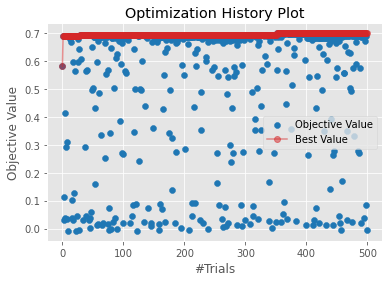

In [165]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_svm);

In [166]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_svm);

In [167]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.713830,0.034916
1,TP,166.100000,5.877452
2,TN,89.500000,5.169354
3,FP,23.900000,4.175324
4,FN,17.600000,5.168279
5,Accuracy,0.860312,0.019678
6,Precision,0.874495,0.019568
7,Sensitivity,0.904297,0.027356
8,Specificity,0.789290,0.036002
9,F1 score,0.888838,0.016155


In [168]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test['std'] = mat_met_svm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.673671,0.721557,0.722501,0.705563,0.728225,0.737113,0.714586,0.686813,0.715745,0.718249,0.712402,0.019145
1,TP,320.000000,341.000000,328.000000,327.000000,328.000000,336.000000,328.000000,323.000000,312.000000,333.000000,327.600000,8.181279
2,TN,176.000000,168.000000,191.000000,182.000000,181.000000,185.000000,172.000000,180.000000,182.000000,173.000000,179.000000,6.815016
3,FP,61.000000,50.000000,46.000000,49.000000,49.000000,37.000000,60.000000,48.000000,62.000000,47.000000,50.900000,7.866243
4,FN,38.000000,36.000000,30.000000,37.000000,37.000000,37.000000,35.000000,44.000000,39.000000,42.000000,37.500000,3.807887
5,Accuracy,0.833613,0.855462,0.872269,0.855462,0.855462,0.875630,0.840336,0.845378,0.830252,0.850420,0.851429,0.014890
6,Precision,0.839895,0.872123,0.877005,0.869681,0.870027,0.900804,0.845361,0.870620,0.834225,0.876316,0.865606,0.020119
7,Sensitivity,0.893855,0.904509,0.916201,0.898352,0.898630,0.900804,0.903581,0.880109,0.888889,0.888000,0.897293,0.010157
8,Specificity,0.742600,0.770600,0.805900,0.787900,0.787000,0.833300,0.741400,0.789500,0.745900,0.786400,0.779050,0.029600
9,F1 score,0.866035,0.888021,0.896175,0.883784,0.884097,0.900804,0.873502,0.875339,0.860690,0.882119,0.881057,0.012539


In [169]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_svm_cat = np.where((y_pred_optimized_svm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_run0.sort_values(by='y_test_idx0', inplace=True)
svm_run0.reset_index(inplace=True, drop=True)
svm_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_run1.sort_values(by='y_test_idx1', inplace=True)
svm_run1.reset_index(inplace=True, drop=True)
svm_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_run2.sort_values(by='y_test_idx2', inplace=True)
svm_run2.reset_index(inplace=True, drop=True)
svm_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_run3.sort_values(by='y_test_idx3', inplace=True)
svm_run3.reset_index(inplace=True, drop=True)
svm_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_run4.sort_values(by='y_test_idx4', inplace=True)
svm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
svm_5preds = pd.concat([chembl_id, svm_run0, svm_run1, svm_run2, svm_run3, svm_run4], axis=1)
svm_5preds = svm_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds['y_pred_svm_ave'] = svm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds['y_pred_svm_std'] = svm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
svm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_svm0,y_pred_svm1,y_pred_svm2,y_pred_svm3,y_pred_svm4,y_pred_svm_ave,y_pred_svm_std
0,CHEMBL356066,0,8.02,7.112791,7.158699,7.249718,7.168090,7.228336,7.322939,0.314992
1,CHEMBL3652228,1,8.05,8.057669,8.010474,7.998303,8.077573,8.073258,8.044546,0.030046
2,CHEMBL3939518,2,6.87,7.376885,7.318239,7.424905,7.482932,7.362245,7.305868,0.201609
3,CHEMBL4281792,3,7.22,8.251271,7.829983,7.629744,8.149521,7.829861,7.818397,0.339352
4,CHEMBL4070232,4,7.15,6.697583,6.501944,6.603923,6.686166,6.670043,6.718277,0.204143
...,...,...,...,...,...,...,...,...,...,...
2966,CHEMBL4202521,2966,7.43,6.956408,6.937631,6.983168,6.970883,6.818440,7.016088,0.192887
2967,CHEMBL216641,2967,7.35,7.139385,7.184603,7.286296,7.145974,7.426355,7.255436,0.107684
2968,CHEMBL3693750,2968,7.43,7.710396,7.773071,7.794279,7.790296,7.739841,7.706314,0.126976
2969,CHEMBL152665,2969,5.96,5.876373,5.937037,5.882080,5.776774,5.883628,5.885982,0.057915


In [170]:
mat_met_optimized_svm.to_csv('mat_met_svm_opt.csv')
svm_5preds.to_csv('svm_5test_CV_result.csv')

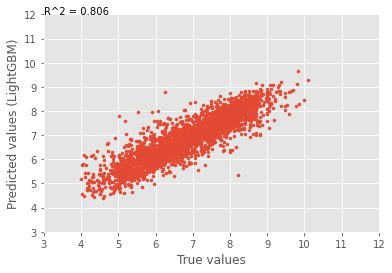

In [171]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'])), (3, 12))
plt.show()

In [172]:
#cross valide using this optimized SVR 
svm_baseline_CVscore = cross_val_score(svm_reg, X, Y, cv=10, scoring="r2")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="r2")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="r2")
print("SVM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model r2_score 0.6860 with a standard deviation of 0.0432
SVM optimized model r2_score 0.7065 with a standard deviation of 0.0425


In [173]:
joblib.dump(svm_reg, "./svm_reg.joblib")
#joblib.dump(optimized_svm, "./optimized_svm.joblib")
joblib.dump(optimizedCV_svm, "./optimizedCV_svm.joblib")

['./optimizedCV_svm.joblib']